# ML : TAM feature 적용

## 라이브러리 설치

In [ ]:
# ================================
# 기본 라이브러리 & 유틸
# ================================
import os
import glob
import random
import warnings
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# ================================
# 통계 / 수학 관련
# ================================
from scipy import stats
from scipy.stats import skew, kurtosis, entropy, zscore

# ================================
# 스키마 분석 / 전처리
# ================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ================================
# 머신러닝 모델들
# ================================
from xgboost import XGBClassifier

# ================================
# 모델 평가 지표
# ================================
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
)

# ================================
# PyTorch
# ================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ================================
# Google Colab
# ================================
from google.colab import drive

# 경고 무시 설정
warnings.filterwarnings('ignore')


## Data Unzip

In [ ]:
!unzip -q "/content/mon_50.zip" -d "/content"

In [ ]:
!unzip "/content/unmon_5000.zip" -d "/content"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/unmon_5000/3673_split_2.cell  
  inflating: /content/unmon_5000/1018_split_3.cell  
  inflating: /content/unmon_5000/3885_join.cell  
  inflating: /content/unmon_5000/1130_split_2.cell  
  inflating: /content/unmon_5000/4865_split_0.cell  
  inflating: /content/unmon_5000/1344_split_2.cell  
  inflating: /content/unmon_5000/974_join.cell  
  inflating: /content/unmon_5000/3807_split_1.cell  
  inflating: /content/unmon_5000/2860_split_2.cell  
  inflating: /content/unmon_5000/706_split_1.cell  
  inflating: /content/unmon_5000/823_split_4.cell  
  inflating: /content/unmon_5000/508_split_1.cell  
  inflating: /content/unmon_5000/70_split_0.cell  
  inflating: /content/unmon_5000/1722_split_2.cell  
  inflating: /content/unmon_5000/1715_split_3.cell  
  inflating: /content/unmon_5000/3_split_1.cell  
  inflating: /content/unmon_5000/2336_split_3.cell  
  inflating: /content/unmon_5000/3332_split_0.cell  
  inflating: /content/unm

In [ ]:
# Data path
mon_50_path = '/content/mon_50'
unmon_5000_path = '/content/unmon_5000'

### Data Structure & File inspection

In [ ]:
def analyze_mon_structure(path):
    print("\n" + "=" * 60)
    print(f" Monitored 데이터 구조 분석: '{path}'")
    print("=" * 60)

    # 1. 모든 .cell 파일 가져오기
    files = glob.glob(os.path.join(path, "*.cell"))
    total_files = len(files)

    if total_files == 0:
        print(f" 경로에 .cell 파일이 없습니다. 경로를 확인해주세요.")
        return

    # 2. 파일명 파싱
    labels = []
    instances = []
    types = []

    for file_path in files:
        filename = os.path.basename(file_path)
        name_body = filename.replace('.cell', '')

        try:
            # 포맷: [Label]-[Instance]_[Type].cell
            parts = name_body.split('_')
            if len(parts) >= 2:
                type_part = "_".join(parts[1:])
                id_part = parts[0]
                label, instance = id_part.split('-')

                labels.append(int(label))
                instances.append(int(instance))
                types.append(type_part)
        except Exception as e:
            print(f" 파일명 파싱 에러 ({filename}): {e}")

    # 3. 통계 계산
    unique_labels = sorted(list(set(labels)))
    # (라벨, 인스턴스) 쌍의 집합 -> 실제 수집된 Trace 개수
    unique_trace_pairs = set(zip(labels, instances))

    # 라벨별 인스턴스 개수 카운트 (파일 개수가 아니라 인스턴스 개수 기준)
    label_instance_counts = Counter([l for l, i in unique_trace_pairs])

    # 4. 출력
    print(f"\n [1] 기본 통계 정보")
    print(f"  - 총 파일 개수 : {total_files:,} 개")
    print(f"  - 라벨 범위    : {min(unique_labels)} ~ {max(unique_labels)}")
    print(f"  - 총 라벨 수   : {len(unique_labels)} 개")
    print(f"  - 총 인스턴스  : {len(unique_trace_pairs):,} 개 (수집 횟수)")

    print(f"\n [1-1] 라벨별 인스턴스 분포")
    counts = list(label_instance_counts.values())

    # 데이터가 균형잡혀 있는지 확인 (모든 라벨의 개수가 같은지)
    if len(set(counts)) == 1:
        print(f"  데이터 균형(Balanced): 모든 라벨({len(unique_labels)}개)이 각각 '{counts[0]}개'의 인스턴스를 가집니다.")
    else:
        print(f"  데이터 불균형(Imbalanced) 감지!")
        print(f"  - 최소 보유 라벨: {min(counts)}개")
        print(f"  - 최대 보유 라벨: {max(counts)}개")
        print(f"  - 상세 분포 (상위/하위 3개):")

        # 개수순 정렬
        sorted_counts = sorted(label_instance_counts.items(), key=lambda x: x[1])
        for l, c in sorted_counts[:3]:
            print(f"    • Label {l:<3}: {c}개 (최소)")
        print("      ...")
        for l, c in sorted_counts[-3:]:
            print(f"    • Label {l:<3}: {c}개 (최대)")

    print(f"\n [2] 파일 타입 분포 (BWR 분할)")
    type_counts = Counter(types)
    for t, count in sorted(type_counts.items()):
        print(f"    • {t:<10} : {count:>6,} 개")

    # 무결성 검증
    expected_files_per_instance = 6
    expected_total = len(unique_trace_pairs) * expected_files_per_instance

    print(f"\n [3] 데이터 무결성 검증")
    print(f"  - 예상 파일 수 : {len(unique_trace_pairs):,} * {expected_files_per_instance} = {expected_total:,} 개")

    if total_files == expected_total:
        print(f"  검증 성공: 모든 인스턴스가 완벽하게 {expected_files_per_instance}개의 파일을 보유 중입니다.")
    else:
        print(f"  검증 실패: 파일 개수 불일치 (현재: {total_files:,} != 예상: {expected_total:,})")


def analyze_unmon_structure(path):
    # (Unmon 데이터는 라벨이 없으므로 기존과 동일하게 유지)
    print("\n" + "=" * 60)
    print(f" Unmonitored 데이터 구조 분석: '{path}'")
    print("=" * 60)

    files = glob.glob(os.path.join(path, "*.cell"))
    total_files = len(files)

    if total_files == 0:
        print(f" 경로에 .cell 파일이 없습니다.")
        return

    instances = []
    types = []

    for file_path in files:
        filename = os.path.basename(file_path)
        name_body = filename.replace('.cell', '')
        try:
            parts = name_body.split('_')
            instance_id = int(parts[0])
            type_part = "_".join(parts[1:])
            instances.append(instance_id)
            types.append(type_part)
        except Exception as e:
            print(f" 파싱 에러 ({filename}): {e}")

    unique_instances = sorted(list(set(instances)))

    print(f"\n [1] 기본 통계 정보")
    print(f"  - 총 파일 개수 : {total_files:,} 개")
    print(f"  - 인스턴스 ID  : {min(unique_instances)} ~ {max(unique_instances)}")
    print(f"  - 총 인스턴스  : {len(unique_instances):,} 개")

    print(f"\n [2] 파일 타입 분포")
    type_counts = Counter(types)
    for t, count in sorted(type_counts.items()):
        print(f"    • {t:<10} : {count:>6,} 개")

    expected_files_per_instance = 6
    expected_total = len(unique_instances) * expected_files_per_instance

    print(f"\n [3] 데이터 무결성 검증")
    print(f"  - 예상 파일 수 : {len(unique_instances):,} * {expected_files_per_instance} = {expected_total:,} 개")

    if total_files == expected_total:
        print(f"  검증 성공: 모든 인스턴스가 완벽하게 파일을 보유 중입니다.")
    else:
        print(f"  검증 실패: 파일 개수 불일치")

def inspect_file_content(path):
    print("\n" + "-" * 60)
    print(f" 파일 내부 데이터 샘플링")
    print("-" * 60)

    files = glob.glob(os.path.join(path, "*.cell"))
    if not files: return

    sample_file = files[0]
    try:
        with open(sample_file, 'r') as f:
            lines = f.readlines()
            print(f"  • 대상 파일 : {os.path.basename(sample_file)}")
            print(f"  • 총 라인 수: {len(lines):,} (패킷 수)")
            print(f"  • 상위 5줄 미리보기:")
            for i, line in enumerate(lines[:5]):
                print(f"    Line {i+1}: {line.strip()}")
    except Exception as e:
        print(f" 파일 읽기 실패: {e}")

In [ ]:
# mon 분석
analyze_mon_structure(mon_50_path)
inspect_file_content(mon_50_path)


 Monitored 데이터 구조 분석: '/content/mon_50'

 [1] 기본 통계 정보
  - 총 파일 개수 : 60,000 개
  - 라벨 범위    : 0 ~ 49
  - 총 라벨 수   : 50 개
  - 총 인스턴스  : 10,000 개 (수집 횟수)

 [1-1] 라벨별 인스턴스 분포
  데이터 균형(Balanced): 모든 라벨(50개)이 각각 '200개'의 인스턴스를 가집니다.

 [2] 파일 타입 분포 (BWR 분할)
    • join       : 10,000 개
    • split_0    : 10,000 개
    • split_1    : 10,000 개
    • split_2    : 10,000 개
    • split_3    : 10,000 개
    • split_4    : 10,000 개

 [3] 데이터 무결성 검증
  - 예상 파일 수 : 10,000 * 6 = 60,000 개
  검증 성공: 모든 인스턴스가 완벽하게 6개의 파일을 보유 중입니다.

------------------------------------------------------------
 파일 내부 데이터 샘플링
------------------------------------------------------------
  • 대상 파일 : 16-125_split_1.cell
  • 총 라인 수: 2,155 (패킷 수)
  • 상위 5줄 미리보기:
    Line 1: 0.0	-1	-512.0
    Line 2: 0.127	-1	-512.0
    Line 3: 0.1271	1	512.0
    Line 4: 0.175	-1	-512.0
    Line 5: 0.1751	1	512.0


In [ ]:
# unmon 분석
analyze_unmon_structure(unmon_5000_path)
inspect_file_content(unmon_5000_path)


 Unmonitored 데이터 구조 분석: '/content/unmon_5000'

 [1] 기본 통계 정보
  - 총 파일 개수 : 30,000 개
  - 인스턴스 ID  : 0 ~ 4999
  - 총 인스턴스  : 5,000 개

 [2] 파일 타입 분포
    • join       :  5,000 개
    • split_0    :  5,000 개
    • split_1    :  5,000 개
    • split_2    :  5,000 개
    • split_3    :  5,000 개
    • split_4    :  5,000 개

 [3] 데이터 무결성 검증
  - 예상 파일 수 : 5,000 * 6 = 30,000 개
  검증 성공: 모든 인스턴스가 완벽하게 파일을 보유 중입니다.

------------------------------------------------------------
 파일 내부 데이터 샘플링
------------------------------------------------------------
  • 대상 파일 : 2480_split_4.cell
  • 총 라인 수: 1,296 (패킷 수)
  • 상위 5줄 미리보기:
    Line 1: 0.0	-1	-512.0
    Line 2: 0.0015000000000000568	-1	-512.0
    Line 3: 0.0015000000000000568	-1	-512.0
    Line 4: 0.0034999999999998366	-1	-512.0
    Line 5: 0.011499999999999844	-1	-512.0


## Load Data

In [ ]:
def load_mon_data(data_path):
    """
    Monitored 데이터를 읽어서 계층적 딕셔너리로 반환합니다.
    구조: data[label][instance_id] = { 'join': np.array, 'split_0': np.array, ... }
    """
    folder_name = os.path.basename(data_path)
    files = glob.glob(os.path.join(data_path, "*.cell"))
    total_files = len(files)

    dataset = {}

    print("\n" + "=" * 60)
    print(f" [START] Monitored Data Loader: '{folder_name}'")
    print(f"  총 {total_files:,}개 파일 발견. 처리 시작...")
    print("=" * 60)

    for file_path in tqdm(files):
        filename = os.path.basename(file_path)
        name_body = filename.replace('.cell', '')

        try:
            # 파일명 파싱: 0-100_split_0 -> Label:0, Inst:100, Type:split_0
            parts = name_body.split('_')
            id_part = parts[0]
            type_part = "_".join(parts[1:])

            label_str, instance_str = id_part.split('-')
            label = int(label_str)
            instance = int(instance_str)

            # 데이터 읽기
            if os.path.getsize(file_path) == 0:
                packet_data = np.empty((0, 3))
            else:
                packet_data = np.loadtxt(file_path)
                if packet_data.ndim == 1:
                    packet_data = packet_data.reshape(1, -1)

        except Exception as e:
            print(f" 파일 읽기/파싱 오류 ({filename}): {e}")
            continue

        if label not in dataset:
            dataset[label] = {}
        if instance not in dataset[label]:
            dataset[label][instance] = {}

        dataset[label][instance][type_part] = packet_data

    print(f"\nMonitored 데이터 로딩 완료. 총 라벨 수: {len(dataset)}개")
    return dataset


def load_unmon_data(data_path, label_value=-1):
    """
    Unmonitored 데이터를 읽어서 mon 데이터와 동일한 구조의 딕셔너리로 반환합니다.
    """
    folder_name = os.path.basename(data_path)
    files = glob.glob(os.path.join(data_path, "*.cell"))
    total_files = len(files)

    dataset = {}
    dataset[label_value] = {} # Unmonitored 라벨 고정

    print("\n" + "=" * 60)
    print(f" [START] Unmonitored Data Loader: '{folder_name}'")
    print(f"  총 {total_files:,}개 파일 발견. 라벨 {label_value}로 처리 시작...")
    print("=" * 60)

    for file_path in tqdm(files):
        filename = os.path.basename(file_path)
        name_body = filename.replace('.cell', '')

        try:
            # 파일명 파싱: [Instance]_[Type].cell
            parts = name_body.split('_')
            instance_str = parts[0]
            instance = int(instance_str)
            type_part = "_".join(parts[1:])

            # 데이터 읽기
            if os.path.getsize(file_path) == 0:
                packet_data = np.empty((0, 3))
            else:
                packet_data = np.loadtxt(file_path)
                if packet_data.ndim == 1:
                    packet_data = packet_data.reshape(1, -1)

        except Exception as e:
            print(f" 파일 읽기/파싱 오류 ({filename}): {e}")
            continue

        # 딕셔너리 구조 생성 (고정된 라벨 사용)
        if instance not in dataset[label_value]:
            dataset[label_value][instance] = {}

        dataset[label_value][instance][type_part] = packet_data

    print(f"\nUnmonitored 데이터 로딩 완료. 고정 라벨: {label_value}")
    return dataset

In [ ]:
# 1. Monitored 데이터 로드
mon_data = load_mon_data('./mon_50')

# 2. Unmonitored 데이터 로드 (Label -1로 지정)
unmon_data = load_unmon_data('./unmon_5000', label_value=-1)


 [START] Monitored Data Loader: 'mon_50'
  총 60,000개 파일 발견. 처리 시작...


100%|██████████| 60000/60000 [00:42<00:00, 1395.79it/s]



Monitored 데이터 로딩 완료. 총 라벨 수: 50개

 [START] Unmonitored Data Loader: 'unmon_5000'
  총 30,000개 파일 발견. 라벨 -1로 처리 시작...


100%|██████████| 30000/30000 [00:25<00:00, 1169.31it/s]


Unmonitored 데이터 로딩 완료. 고정 라벨: -1


### Loaded data sturcture

In [ ]:
import numpy as np
from collections import Counter

def summarize_dataset_structure(dataset, name="Dataset"):
    print("\n" + "═" * 70)
    print(f" 데이터 구조 상세 요약: {name}")
    print("═" * 70)

    labels = list(dataset.keys())

    # 1. 기본 정보 확인
    if not labels:
        print(" 데이터셋이 비어 있습니다. 로딩을 확인해주세요.")
        return

    print(f" [1] 기본 정보")
    print(f"  • 총 라벨(클래스) 수   : {len(labels)}개")

    # 2. 라벨별 인스턴스 개수 확인 및 균형 분석

    # 각 라벨이 보유한 인스턴스(Trace) 개수
    instance_counts = [len(dataset[label]) for label in labels]
    label_instance_pairs = list(zip(labels, instance_counts))

    print(f"\n [2] 데이터 분포 분석 (Instance Count)")

    if len(labels) == 1 and labels[0] == -1:
        # Unmonitored 데이터인 경우
        print(f"  • 데이터 유형 : Unmonitored (단일 클래스)")
        print(f"  • 총 인스턴스 : {instance_counts[0]:,} 개")
    else:
        # Monitored 데이터인 경우 (균형 체크)
        unique_counts = set(instance_counts)
        print(f"  • 라벨 범위   : {min(labels)} ~ {max(labels)}")
        print(f"  • 총 인스턴스 : {sum(instance_counts):,} 개")

        if len(unique_counts) == 1:
            print(f"  데이터 균형: 모든 라벨이 동일하게 {instance_counts[0]}개의 인스턴스를 가집니다.")
        else:
            print(f"  데이터 불균형 감지 (Instance Count 편차):")
            sorted_counts = sorted(label_instance_pairs, key=lambda x: x[1])

            print(f"    - 최소 개수 라벨: Label {sorted_counts[0][0]:<3} ({sorted_counts[0][1]}개)")
            print(f"    - 최대 개수 라벨: Label {sorted_counts[-1][0]:<3} ({sorted_counts[-1][1]}개)")


    # 3. 샘플 데이터 구조 확인 (가장 깊은 곳까지 Drill-down)

    # 첫 번째 라벨 선택
    first_label = labels[0]
    instances = dataset[first_label]

    # 첫 번째 인스턴스 ID와 타입 목록 확인
    first_inst_id = list(instances.keys())[0]
    types = instances[first_inst_id]

    # 첫 번째 타입의 실제 Numpy 배열 확인
    first_type = list(types.keys())[0]
    data_matrix = types[first_type]

    print(f"\n [3] 샘플 데이터 상세 구조")
    print(f"  • 선택 라벨   : {first_label} (인스턴스 {len(instances):,}개 보유)")
    print(f"  • 샘플 인스턴스: {first_inst_id}")
    print(f"  • 보유 타입   : {list(types.keys())}")

    # Numpy Array Shape 및 내용 확인
    print(f"  • 샘플 데이터 ('{first_type}') 모양: {data_matrix.shape}")
    print(f"    - 행(Row)    : 패킷 수 (N)")
    print(f"    - 열(Column) : 3개")

    print(f"  • 데이터 내용 (컬럼 3개 의미):")
    print(f"    Col 0: Time | Col 1: Direction | Col 2: Signed Size (Packet Value)")

    print("\n   [실제 데이터 미리보기 (상위 5줄)]")
    print("   " + "-"*50)
    for row in data_matrix[:5]:
        # 소수점 4자리까지 출력하여 가독성 높임
        print(f"   Time: {row[0]:<10.4f} | Dir: {row[1]:<5.0f} | Size: {row[2]:.1f}")
    print("   " + "-"*50)

In [ ]:
summarize_dataset_structure(mon_data, "Monitored Data")
summarize_dataset_structure(unmon_data, "Unmonitored Data")


══════════════════════════════════════════════════════════════════════
 데이터 구조 상세 요약: Monitored Data
══════════════════════════════════════════════════════════════════════
 [1] 기본 정보
  • 총 라벨(클래스) 수   : 50개

 [2] 데이터 분포 분석 (Instance Count)
  • 라벨 범위   : 0 ~ 49
  • 총 인스턴스 : 10,000 개
  데이터 균형: 모든 라벨이 동일하게 200개의 인스턴스를 가집니다.

 [3] 샘플 데이터 상세 구조
  • 선택 라벨   : 16 (인스턴스 200개 보유)
  • 샘플 인스턴스: 125
  • 보유 타입   : ['split_1', 'join', 'split_3', 'split_4', 'split_2', 'split_0']
  • 샘플 데이터 ('split_1') 모양: (2155, 3)
    - 행(Row)    : 패킷 수 (N)
    - 열(Column) : 3개
  • 데이터 내용 (컬럼 3개 의미):
    Col 0: Time | Col 1: Direction | Col 2: Signed Size (Packet Value)

   [실제 데이터 미리보기 (상위 5줄)]
   --------------------------------------------------
   Time: 0.0000     | Dir: -1    | Size: -512.0
   Time: 0.1270     | Dir: -1    | Size: -512.0
   Time: 0.1271     | Dir: 1     | Size: 512.0
   Time: 0.1750     | Dir: -1    | Size: -512.0
   Time: 0.1751     | Dir: 1     | Size: 512.0
   ------------------------------

## Feature Extraction

In [ ]:
# ----------------------------------------------------------------------
# [Helper] 안전한 엔트로피 계산 (Base Code 로직 수용)
# ----------------------------------------------------------------------
def safe_entropy(values, method='shannon'):
    """
    데이터 리스트나 카운트가 들어오면 엔트로피를 계산
    method: 'shannon' (기본), 'bin' (구간화 후 계산)
    """
    if len(values) == 0:
        return 0.0

    # 카운트가 아니라 raw data가 들어온 경우 분포로 변환
    counts = Counter(values)
    probs = np.array(list(counts.values())) / len(values)

    # 0 확률 제거 (Log 계산 오류 방지)
    probs = probs[probs > 1e-9]
    return float(entropy(probs, base=2)) # Log2 base entropy

# ----------------------------------------------------------------------
# [Main] 최종 통합 특징 추출 함수
# ----------------------------------------------------------------------
def extract_features(time_seq, size_seq, mode="outgoing", bin_size=0.2, fine_slot_size=0.05):

    # 1. 데이터 전처리 및 기본 변수
    size_seq = np.array(size_seq, dtype=float)
    time_seq = np.array(time_seq, dtype=float)
    Total_Packets = len(size_seq)

    if Total_Packets < 2:
        return {} # 데이터가 너무 적음

    raw_duration = time_seq[-1] - time_seq[0]
    Total_Time = raw_duration if raw_duration > 0 else 1e-9

    features = {}

    # =========================================================
    # [Group 1] Basic & Direction Stats
    # =========================================================
    out_mask = size_seq > 0
    in_mask = size_seq < 0

    features["Total_Packets"] = Total_Packets
    features["Total_Time"] = Total_Time
    features["Num_Outgoing"] = np.sum(out_mask)
    features["Num_Incoming"] = np.sum(in_mask)
    features["Out_Ratio"] = features["Num_Outgoing"] / Total_Packets
    features["In_Ratio"] = features["Num_Incoming"] / Total_Packets

    # 전송량(Bytes) 통계
    features["Total_Incoming_Bytes"] = np.sum(np.abs(size_seq[in_mask]))
    features["Total_Outgoing_Bytes"] = np.sum(size_seq[out_mask])
    features["Packet_Rate"] = Total_Packets / Total_Time

    # =========================================================
    # [Group 2] Size Statistics
    # =========================================================
    features["Mean_Size"] = np.mean(size_seq)
    features["Std_Size"] = np.std(size_seq)
    features["Skew_Size"] = skew(size_seq)

    # 상세 통계
    features["Median_Size"] = np.median(size_seq)
    features["Min_Size"] = np.min(size_seq)
    features["Max_Size"] = np.max(size_seq)
    features["Kurt_Size"] = kurtosis(size_seq)
    features["Size_25th"] = np.percentile(size_seq, 25)
    features["Size_75th"] = np.percentile(size_seq, 75)
    features["Size_IQR"] = features["Size_75th"] - features["Size_25th"]

    # 방향별 평균 크기
    features["Mean_Incoming_Size"] = np.mean(np.abs(size_seq[in_mask])) if np.any(in_mask) else 0
    features["Mean_Outgoing_Size"] = np.mean(size_seq[out_mask]) if np.any(out_mask) else 0

    # =========================================================
    # [Group 3] IAT (Inter-Arrival Time)
    # =========================================================
    # (1) Global IAT
    inter_global = np.diff(time_seq)
    inter_global = inter_global[inter_global > 0]

    if len(inter_global) > 0:
        features["Mean_Inter_Time"] = np.mean(inter_global)
        features["Std_Inter_Time"] = np.std(inter_global)
        features["Max_Inter_Time"] = np.max(inter_global)
    else:
        features["Mean_Inter_Time"] = 0
        features["Std_Inter_Time"] = 0
        features["Max_Inter_Time"] = 0

    # (2) Outgoing Only IAT
    out_idx = np.where(out_mask)[0]
    if len(out_idx) > 1:
        t_out = np.sort(time_seq[out_idx])
        iat_out = np.diff(t_out)
        iat_out = iat_out[iat_out > 0]
        if len(iat_out) > 0:
            features["IAT_Out_Mean"] = np.mean(iat_out)
            features["IAT_Out_Std"] = np.std(iat_out)
            features["IAT_Out_Skew"] = skew(iat_out)
        else:
            features["IAT_Out_Mean"] = 0
            features["IAT_Out_Std"] = 0
            features["IAT_Out_Skew"] = 0
    else:
        features["IAT_Out_Mean"] = 0
        features["IAT_Out_Std"] = 0
        features["IAT_Out_Skew"] = 0

    # =========================================================
    # [Group 4] Burst & Structural
    # =========================================================
    Signs = np.sign(size_seq)
    Burst_Lengths, Burst_Sizes, Burst_Dirs = [], [], []

    if len(Signs) > 0:
        Cur_Sign, Cur_Len, Cur_Sum = Signs[0], 1, abs(size_seq[0])
        for i in range(1, len(size_seq)):
            s = size_seq[i]
            if np.sign(s) == Cur_Sign:
                Cur_Len += 1
                Cur_Sum += abs(s)
            else:
                Burst_Lengths.append(Cur_Len)
                Burst_Sizes.append(Cur_Sum)
                Burst_Dirs.append(Cur_Sign) # 방향 저장
                Cur_Sign, Cur_Len, Cur_Sum = np.sign(s), 1, abs(s)
        # 마지막 버스트
        Burst_Lengths.append(Cur_Len)
        Burst_Sizes.append(Cur_Sum)
        Burst_Dirs.append(Cur_Sign)

    if not Burst_Lengths:
        Burst_Lengths, Burst_Sizes = [0], [0]

    features["Num_Bursts"] = len(Burst_Lengths)
    features["Mean_Burst_Length"] = np.mean(Burst_Lengths)
    features["Mean_Burst_Size"] = np.mean(Burst_Sizes)
    features["Max_Burst_Size"] = np.max(Burst_Sizes)

    features["Sign_Flip_Count"] = len(Burst_Lengths) - 1 if len(Burst_Lengths) > 0 else 0
    features["Diff_Mean"] = np.mean(np.diff(size_seq))

    # =========================================================
    # [Group 5] Position-based Features
    # =========================================================
    # 트래픽 초반/후반의 패턴은 Handshake 등을 포함
    K = min(30, Total_Packets)
    first_K = size_seq[:K]
    last_K = size_seq[-K:]

    features["First_30_Outgoing"] = np.sum(first_K > 0)
    features["First_30_Incoming"] = np.sum(first_K < 0)
    features["Last_30_Outgoing"] = np.sum(last_K > 0)
    features["Last_30_Incoming"] = np.sum(last_K < 0)

    # 1초 이내 패킷 수
    features["Packets_First_Second"] = np.sum(time_seq <= (time_seq[0] + 1.0))
    features["Packets_Last_Second"] = np.sum(time_seq >= (time_seq[-1] - 1.0))

    # =========================================================
    # [Group 6] Entropy Features
    # =========================================================
    # (1) Direction Entropy (+1/-1 분포)
    directions = Signs[Signs != 0]
    features["Direction_Entropy"] = safe_entropy(directions)

    # (2) Burst Direction Entropy (버스트 단위 방향 분포)
    features["Burst_Direction_Entropy"] = safe_entropy(Burst_Dirs)

    # (3) Size Bin Entropy (크기 분포)
    # 절대값 기준 0~1500 바이트를 20개 구간으로 나눔
    abs_sz = np.abs(size_seq)
    size_bins = np.digitize(abs_sz, bins=np.linspace(0, 1500, 21))
    features["Size_Bin_Entropy"] = safe_entropy(size_bins)

    # (4) IAT Bin Entropy (시간 간격 분포)
    if len(inter_global) > 0 and Total_Time > 0:
        iat_norm = inter_global / Total_Time
        iat_bins = np.digitize(iat_norm, bins=np.linspace(0, 1, 11))
        features["IAT_Bin_Entropy"] = safe_entropy(iat_bins)
    else:
        features["IAT_Bin_Entropy"] = 0

    # =========================================================
    # [Group 7] Cumulative & Robust
    # =========================================================
    Cumulative = np.cumsum(size_seq)
    max_cum = np.max(np.abs(Cumulative))
    features["Max_Cumulative"] = np.max(Cumulative)
    features["CumNorm_Mean"] = np.mean(Cumulative / (max_cum + 1e-9))
    features["CumNorm_Std"] = np.std(Cumulative / (max_cum + 1e-9))

    # Time to X% Volume (Robustness)
    Abs_Cum_Size = np.cumsum(np.abs(size_seq))
    Total_Vol = Abs_Cum_Size[-1] if len(Abs_Cum_Size) > 0 else 1
    Norm_Cum_Size = Abs_Cum_Size / Total_Vol
    rel_times = time_seq - time_seq[0]

    for cp in [0.1, 0.5, 0.9]:
        idx = np.argmax(Norm_Cum_Size >= cp)
        features[f"Time_to_Cum_{int(cp*100)}p"] = rel_times[idx]

    # =========================================================
    # [Group 8] Advanced TAM: Slot & Binning
    # =========================================================
    # (1) 0.2s Coarse Binning (전체적 형상)
    Bin_Size = bin_size
    Num_Bins = int(np.ceil(Total_Time / Bin_Size))
    Num_Bins = min(Num_Bins, 300) # Max 60초 제한 등 안전장치

    Bin_IN = np.zeros(Num_Bins)
    Bin_OUT = np.zeros(Num_Bins)

    for t, s in zip(rel_times, size_seq):
        idx = min(int(t // Bin_Size), Num_Bins - 1)
        if s > 0: Bin_OUT[idx] += 1
        else:     Bin_IN[idx] += 1

    features['Bin_IN_Mean'] = np.mean(Bin_IN)
    features['Bin_OUT_Mean'] = np.mean(Bin_OUT)

    # (2) 0.05s Fine Slot Stats (미세 텍스처)
    Fine_Slot_Size = fine_slot_size
    n_fine = int(np.ceil(Total_Time / Fine_Slot_Size))
    if n_fine == 0: n_fine = 1

    Fine_IN = np.zeros(n_fine)
    Fine_OUT = np.zeros(n_fine)

    for t, s in zip(rel_times, size_seq):
        idx = min(int(t / Fine_Slot_Size), n_fine-1)
        if s < 0: Fine_IN[idx] += 1
        else:     Fine_OUT[idx] += 1

    # 분포 통계 (Skew, Kurtosis, Sparsity)
    features["Fine_IN_Skew"] = skew(Fine_IN) if len(Fine_IN) > 1 else 0
    features["Fine_OUT_Skew"] = skew(Fine_OUT) if len(Fine_OUT) > 1 else 0
    features["Fine_IN_NonZero"] = np.count_nonzero(Fine_IN) / n_fine
    features["Fine_OUT_NonZero"] = np.count_nonzero(Fine_OUT) / n_fine

    return features

In [ ]:
def process_dataset_to_df(dataset, min_packets=10, bin_size=0.2, fine_slot_size=0.05):
    """
    [전처리 포함] 데이터셋을 DataFrame으로 변환
    min_packets: 이 숫자보다 패킷이 적으면 '노이즈'로 간주하고 버림 (1차 전처리)
    """
    all_features = []

    # 데이터셋 이름 추출 (mon_data, unmon_data 등)
    dataset_name = next(iter(dataset.keys()), "Unknown_Data") # 0, -1 등 라벨값 사용
    print("\n" + "═" * 60)
    print(f" Feature Extraction 시작 (Label {dataset_name} | Min Pkts: {min_packets})")
    print("═" * 60)

    skip_count = 0
    processed_count = 0

    # 딕셔너리 순회: Label -> Instance -> Type
    for label, instances in tqdm(dataset.items()):
        for instance_id, types in instances.items():
            for type_name, matrix in types.items():

                # 1차 전처리: 필터링
                if matrix.shape[0] < min_packets:
                    skip_count += 1
                    continue

                time_seq = matrix[:, 0]
                size_seq = matrix[:, 2]

                # 특징 추출
                feats = extract_features(time_seq, size_seq, mode="outgoing", bin_size=0.2, fine_slot_size=0.05)

                if not feats:
                    skip_count += 1
                    continue

                feats['label'] = label
                feats['instance_id'] = instance_id
                feats['type'] = type_name

                all_features.append(feats)
                processed_count += 1

    df = pd.DataFrame(all_features)

    # 2차 전처리
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)

    print("-" * 60)
    print(f" 추출 완료.")
    print(f" 최종 크기: {df.shape[0]:,} rows x {df.shape[1]:,} columns")
    print(f" 제외된 짧은 세션 (노이즈): {skip_count:,}개")
    print("-" * 60)
    return df


In [ ]:
# 1. 데이터프레임 생성
df_mon = process_dataset_to_df(mon_data, min_packets=10, fine_slot_size=0.25)
df_unmon = process_dataset_to_df(unmon_data, min_packets=10, fine_slot_size=0.25)

# 2. 결과 확인
print(df_mon.head())
print(df_unmon.head())

# 4. 저장
df_mon.to_pickle('mon_features.pkl')
df_unmon.to_pickle('unmon_features.pkl')


════════════════════════════════════════════════════════════
 Feature Extraction 시작 (Label 16 | Min Pkts: 10)
════════════════════════════════════════════════════════════


100%|██████████| 50/50 [08:04<00:00,  9.70s/it]


------------------------------------------------------------
 추출 완료.
 최종 크기: 55,006 rows x 58 columns
 제외된 짧은 세션 (노이즈): 4,994개
------------------------------------------------------------

════════════════════════════════════════════════════════════
 Feature Extraction 시작 (Label -1 | Min Pkts: 10)
════════════════════════════════════════════════════════════


100%|██████████| 1/1 [04:25<00:00, 265.35s/it]


------------------------------------------------------------
 추출 완료.
 최종 크기: 27,171 rows x 58 columns
 제외된 짧은 세션 (노이즈): 2,829개
------------------------------------------------------------
   Total_Packets  Total_Time  Num_Outgoing  Num_Incoming  Out_Ratio  In_Ratio  \
0           2155     57.1050           254          1901   0.117865  0.882135   
1           9490     57.1051          1423          8067   0.149947  0.850053   
2            974     46.0965           261           713   0.267967  0.732033   
3            712     45.6700           522           190   0.733146  0.266854   
4           2930     47.6880           184          2746   0.062799  0.937201   

   Total_Incoming_Bytes  Total_Outgoing_Bytes  Packet_Rate   Mean_Size  ...  \
0              973312.0              130048.0    37.737501 -391.305800  ...   
1             4130304.0              728576.0   166.184807 -358.453952  ...   
2              365056.0              133632.0    21.129587 -237.601643  ...   
3        

In [ ]:
df_mon.columns.tolist()

['Total_Packets',
 'Total_Time',
 'Num_Outgoing',
 'Num_Incoming',
 'Out_Ratio',
 'In_Ratio',
 'Total_Incoming_Bytes',
 'Total_Outgoing_Bytes',
 'Packet_Rate',
 'Mean_Size',
 'Std_Size',
 'Skew_Size',
 'Median_Size',
 'Min_Size',
 'Max_Size',
 'Kurt_Size',
 'Size_25th',
 'Size_75th',
 'Size_IQR',
 'Mean_Incoming_Size',
 'Mean_Outgoing_Size',
 'Mean_Inter_Time',
 'Std_Inter_Time',
 'Max_Inter_Time',
 'IAT_Out_Mean',
 'IAT_Out_Std',
 'IAT_Out_Skew',
 'Num_Bursts',
 'Mean_Burst_Length',
 'Mean_Burst_Size',
 'Max_Burst_Size',
 'Sign_Flip_Count',
 'Diff_Mean',
 'First_30_Outgoing',
 'First_30_Incoming',
 'Last_30_Outgoing',
 'Last_30_Incoming',
 'Packets_First_Second',
 'Packets_Last_Second',
 'Direction_Entropy',
 'Burst_Direction_Entropy',
 'Size_Bin_Entropy',
 'IAT_Bin_Entropy',
 'Max_Cumulative',
 'CumNorm_Mean',
 'CumNorm_Std',
 'Time_to_Cum_10p',
 'Time_to_Cum_50p',
 'Time_to_Cum_90p',
 'Bin_IN_Mean',
 'Bin_OUT_Mean',
 'Fine_IN_Skew',
 'Fine_OUT_Skew',
 'Fine_IN_NonZero',
 'Fine_OUT_N

In [ ]:
df_unmon.columns.tolist()

['Total_Packets',
 'Total_Time',
 'Num_Outgoing',
 'Num_Incoming',
 'Out_Ratio',
 'In_Ratio',
 'Total_Incoming_Bytes',
 'Total_Outgoing_Bytes',
 'Packet_Rate',
 'Mean_Size',
 'Std_Size',
 'Skew_Size',
 'Median_Size',
 'Min_Size',
 'Max_Size',
 'Kurt_Size',
 'Size_25th',
 'Size_75th',
 'Size_IQR',
 'Mean_Incoming_Size',
 'Mean_Outgoing_Size',
 'Mean_Inter_Time',
 'Std_Inter_Time',
 'Max_Inter_Time',
 'IAT_Out_Mean',
 'IAT_Out_Std',
 'IAT_Out_Skew',
 'Num_Bursts',
 'Mean_Burst_Length',
 'Mean_Burst_Size',
 'Max_Burst_Size',
 'Sign_Flip_Count',
 'Diff_Mean',
 'First_30_Outgoing',
 'First_30_Incoming',
 'Last_30_Outgoing',
 'Last_30_Incoming',
 'Packets_First_Second',
 'Packets_Last_Second',
 'Direction_Entropy',
 'Burst_Direction_Entropy',
 'Size_Bin_Entropy',
 'IAT_Bin_Entropy',
 'Max_Cumulative',
 'CumNorm_Mean',
 'CumNorm_Std',
 'Time_to_Cum_10p',
 'Time_to_Cum_50p',
 'Time_to_Cum_90p',
 'Bin_IN_Mean',
 'Bin_OUT_Mean',
 'Fine_IN_Skew',
 'Fine_OUT_Skew',
 'Fine_IN_NonZero',
 'Fine_OUT_N

### load pkl

In [ ]:
# 파일 경로 정의
MON_PATH = 'mon_features.pkl'
UNMON_PATH = 'unmon_features.pkl'
# 데이터 불러오기
try:
    loaded_mon = pd.read_pickle(MON_PATH)
    loaded_unmon = pd.read_pickle(UNMON_PATH)

    print("데이터 불러오기 성공")
    print(f"Loaded Monitored Data Shape: {loaded_mon.shape}")
    print(f"Loaded Unmonitored Data Shape: {loaded_unmon.shape}")

except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 경로와 파일명을 다시 확인해주세요.")

데이터 불러오기 성공
Loaded Monitored Data Shape: (55006, 58)
Loaded Unmonitored Data Shape: (27171, 58)


### feature set 분리

In [ ]:
def prepare_robust_feature_sets(df):
    print("\n" + "=" * 60)
    print(" Feature Set 그룹화 (v8.1 Ablation Study 준비)")
    print("=" * 60)

    # 1. 메타데이터 제외
    meta_cols = ['label', 'instance_id', 'type']
    feature_cols = [c for c in df.columns if c not in meta_cols]

    # 2. Basic Features 정의 (가장 기초적인 통계만 남김)
    robust_keywords = [
        # [A] 고급 통계 (분포 모양)
        'Skew', 'Kurt', 'Median', 'Min', 'Max', 'IQR', '25th', '75th',

        # [B] 엔트로피 (핵심 Robust)
        'Entropy',

        # [C] 누적 및 시계열 구조
        'Cum', 'Time_to_Cum', 'Sign_Flip', 'Diff_',

        # [D] TAM (Binning & Slot)
        'Bin_', 'Fine_',

        # [E] 위치 정보 (TrafficSliver가 망가뜨리려 하는 것)
        'First_30', 'Packets_First', 'Packets_Last',

        # [F] IAT 상세 (기본 Mean/Std 제외하고 나머지)
        'IAT_Out'
    ]

    # Basic: 위 키워드가 하나도 없는 것들 (Mean, Std, Count, Ratio, Total 등만 남음)
    basic_cols = [
        c for c in feature_cols
        if not any(k in c for k in robust_keywords)
    ]

    # 3. Robust Features: Basic이 아닌 모든 것
    robust_cols = [c for c in feature_cols if c not in basic_cols]

    # 4. 결과 생성
    result = {
        'full': df,
        'basic': df[basic_cols + meta_cols].copy(),   # Baseline
        'robust': df[robust_cols + meta_cols].copy(), # 우리가 제안하는 Robust 특징
    }

    print(f" [1] 전체 데이터 크기: {len(df):,} 샘플")
    print(f" [2] Feature Set 정의:")
    print(f"  • Full (Ultimate) : {len(feature_cols):,} features (모든 특징 사용)")
    print(f"  • Basic (Baseline): {len(basic_cols):,} features (평균, 표준편차, 개수 등 단순 통계)")
    print(f"  • Robust (New)    : {len(robust_cols):,} features (엔트로피, 분포, 누적, 위치 등)")

    print("\n Feature Set 그룹화 완료. 딕셔너리로 반환되었습니다.")
    return result

In [ ]:
mon_sets = prepare_robust_feature_sets(loaded_mon)
unmon_sets = prepare_robust_feature_sets(loaded_unmon)


 Feature Set 그룹화 (v8.1 Ablation Study 준비)
 [1] 전체 데이터 크기: 55,006 샘플
 [2] Feature Set 정의:
  • Full (Ultimate) : 55 features (모든 특징 사용)
  • Basic (Baseline): 20 features (평균, 표준편차, 개수 등 단순 통계)
  • Robust (New)    : 35 features (엔트로피, 분포, 누적, 위치 등)

 Feature Set 그룹화 완료. 딕셔너리로 반환되었습니다.

 Feature Set 그룹화 (v8.1 Ablation Study 준비)
 [1] 전체 데이터 크기: 27,171 샘플
 [2] Feature Set 정의:
  • Full (Ultimate) : 55 features (모든 특징 사용)
  • Basic (Baseline): 20 features (평균, 표준편차, 개수 등 단순 통계)
  • Robust (New)    : 35 features (엔트로피, 분포, 누적, 위치 등)

 Feature Set 그룹화 완료. 딕셔너리로 반환되었습니다.


### feature preprocessing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import logging

from scipy.stats import skew
logging.basicConfig(level=logging.INFO)


class FeaturePreprocessor:
    """
    WF 데이터셋에 최적화된 전처리 파이프라인 메타데이터를 제외한 특징만 학습/변환
    """
    def __init__(self, correlation_threshold=1.0):
        self.correlation_threshold = correlation_threshold
        self.outlier_bounds = {}
        self.medians = {}
        self.scaler = StandardScaler()
        self.corr_features_to_drop = []
        self.variance_selector = None
        self.feature_names = None
        # WF 데이터의 메타 컬럼 정의 (스케일링/필터링 대상에서 제외)
        self.wf_metadata_cols = ['instance_id', 'type']


    def fit(self, df, has_label=True):
        """ Train set에서 전처리 파라미터를 학습 """

        df = df.copy()

        # 1. WF 메타데이터 및 label 제외하고 Features만 추출
        cols_to_drop = ["label"] if has_label else []
        features = df.drop(columns=cols_to_drop + self.wf_metadata_cols, errors='ignore')

        # 2. Outlier bounds 학습 (IQR 기준)
        for col in features.columns:
            s = features[col]
            if (s >= 0).all():
                s_log = np.log1p(s)
                use_log = True
            else:
                s_log = s
                use_log = False

            Q1, Q3 = s_log.quantile(0.25), s_log.quantile(0.75)
            IQR = Q3 - Q1
            self.outlier_bounds[col] = {
                'lower': Q1 - 1.5 * IQR,
                'upper': Q3 + 1.5 * IQR,
                'use_log': use_log
            }

        # 3. Median 학습 (결측치 대체용)
        self.medians = features.median()

        # 4. 전처리 적용된 데이터로 나머지 학습 (fit 내부에서만 사용)
        df_transformed = self._apply_basic_transform(df, has_label)
        features_clean = df_transformed.drop(columns=cols_to_drop + self.wf_metadata_cols, errors='ignore')

        # 5. Standardization 학습
        self.scaler.fit(features_clean)
        features_scaled = pd.DataFrame(self.scaler.transform(features_clean), columns=features_clean.columns)

        # 6. Correlation-based feature 제거
        corr = features_scaled.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        self.corr_features_to_drop = [c for c in upper.columns if any(upper[c] > self.correlation_threshold)]
        features_scaled.drop(columns=self.corr_features_to_drop, errors='ignore', inplace=True)

        # 7. Low variance feature 제거
        self.variance_selector = VarianceThreshold(threshold=1e-4)
        try:
            self.variance_selector.fit(features_scaled)
            self.feature_names = features_scaled.columns[self.variance_selector.get_support()].tolist()
        except Exception as e:
            print(f"VarianceThreshold failed: {e}. Keeping all features.")
            self.feature_names = features_scaled.columns.tolist()
            self.variance_selector = None

        print(f"  Preprocessing learned:")
        print(f"    - Final features count : {len(self.feature_names)}")

        return self


    def _apply_basic_transform(self, df, has_label=True):
        """ Outlier clipping + Imputation만 적용 (fit/transform 내부에서 사용) """
        df = df.copy()

        cols_to_drop = ["label"] if has_label else []
        feature_cols = [c for c in df.columns if c not in cols_to_drop + self.wf_metadata_cols]

        # 1. Outlier clipping
        for col in feature_cols:
            bounds = self.outlier_bounds.get(col)
            if bounds is None: continue
            s = df[col]
            if bounds['use_log']:
                s = np.log1p(s.clip(lower=0))
            df[col] = s.clip(bounds['lower'], bounds['upper'])

        # 2. Median imputation (결측치 대체)
        if self.medians is not None:
            features = df[feature_cols]
            if features.isnull().sum().sum() > 0:
                features.fillna(self.medians, inplace=True)
                df.update(features)

        return df


    def transform(self, df, has_label=True):
        """ 학습된 파라미터로 데이터를 변환 """
        df = df.copy()

        cols_to_drop = ["label"] if has_label else []
        feature_cols = [c for c in df.columns if c not in cols_to_drop + self.wf_metadata_cols]

        # 1. Basic transform (Clipping + Imputation)
        df = self._apply_basic_transform(df, has_label)
        features = df[feature_cols]

        # 2. Standardization
        features_scaled = pd.DataFrame(self.scaler.transform(features), columns=features.columns)

        # 3. Correlation feature 제거
        features_scaled.drop(
            columns=[c for c in self.corr_features_to_drop if c in features_scaled.columns],
            errors='ignore',
            inplace=True
        )

        # 4. Variance feature 제거 및 최종 컬럼 선택
        if self.variance_selector is not None:
            features_final_np = self.variance_selector.transform(features_scaled)
            features_final = pd.DataFrame(features_final_np, columns=self.feature_names)
        else:
            features_final = features_scaled[self.feature_names]

        # 5. Label 재결합 (가장 중요)
        if has_label:
            features_final["label"] = df["label"].values

        return features_final

def apply_wf_preprocessing(df_mon_full, df_unmon_full, corr_threshold = 1.0):
    """
    모니터링 데이터(df_mon_full)에서 전처리 파라미터를 학습하고,
    모든 데이터셋에 적용하여 스케일링된 최종 DataFrame을 반환합니다.
    """
    print("\n" + "=" * 60)
    print(" Feature Preprocessing Pipeline Start")
    print("=" * 60)

    # 1. WF 메타데이터 분리
    MON_META_COLS = ['instance_id', 'type']

    # 학습/변환에 사용할 데이터 준비 (WF 메타데이터 컬럼 제외)
    mon_for_fit = df_mon_full.drop(columns=MON_META_COLS)
    unmon_for_transform = df_unmon_full.drop(columns=MON_META_COLS)

    # 2. Preprocessor 인스턴스화 및 학습 (Fit on Monitored)
    preprocessor = FeaturePreprocessor(corr_threshold)
    print("1. Fitting Preprocessor (Learning parameters on Monitored Data)...")
    preprocessor.fit(mon_for_fit, has_label=True)

    print("\n2. Applying Transform...")

    # 3. Monitored Data 변환 (Transform on Monitored)
    df_mon_scaled = preprocessor.transform(mon_for_fit, has_label=True)

    # 4. Unmonitored Data 변환 (Transform on Unmonitored)
    df_unmon_scaled = preprocessor.transform(unmon_for_transform, has_label=True)

    # 5. WF 메타데이터 재결합 (Final DataFrames)
    df_mon_final = pd.concat([
        df_mon_scaled.reset_index(drop=True),
        df_mon_full[MON_META_COLS].reset_index(drop=True)
    ], axis=1)

    df_unmon_final = pd.concat([
        df_unmon_scaled.reset_index(drop=True),
        df_unmon_full[MON_META_COLS].reset_index(drop=True)
    ], axis=1)

    print("\n" + "-" * 60)
    print("Preprocessing complete.")
    print(f"  - 최종 Feature 개수  : {len(preprocessor.feature_names)}개")
    print(f"  - Mon Final Shape  : {df_mon_final.shape}")
    print(f"  - Unmon Final Shape: {df_unmon_final.shape}")
    print("-" * 60)

    return df_mon_final, df_unmon_final, preprocessor

In [ ]:
# Feature Mode 선택
df_mon_full = mon_sets['full']
df_unmon_full = unmon_sets['full']

df_mon_robust = mon_sets['robust']
df_unmon_robust = unmon_sets['robust']

df_mon_basic = mon_sets['basic']
df_unmon_basic = unmon_sets['basic']


# Feature Mode 별로 preprocessing 실행
df_mon_full_clean, df_unmon_full_clean, preprocessor_obj = apply_wf_preprocessing(
    df_mon_full,
    df_unmon_full,
    corr_threshold = 1.0
)

df_mon_robust_clean, df_unmon_robust_clean, preprocessor_obj = apply_wf_preprocessing(
    df_mon_robust,
    df_unmon_robust,
    corr_threshold = 1.0
)

df_mon_basic_clean, df_unmon_basic_clean, preprocessor_obj = apply_wf_preprocessing(
    df_mon_basic,
    df_unmon_basic,
    corr_threshold = 1.0
)


 Feature Preprocessing Pipeline Start
1. Fitting Preprocessor (Learning parameters on Monitored Data)...
  Preprocessing learned:
    - Final features count : 46

2. Applying Transform...

------------------------------------------------------------
Preprocessing complete.
  - 최종 Feature 개수  : 46개
  - Mon Final Shape  : (55006, 49)
  - Unmon Final Shape: (27171, 49)
------------------------------------------------------------

 Feature Preprocessing Pipeline Start
1. Fitting Preprocessor (Learning parameters on Monitored Data)...
  Preprocessing learned:
    - Final features count : 28

2. Applying Transform...

------------------------------------------------------------
Preprocessing complete.
  - 최종 Feature 개수  : 28개
  - Mon Final Shape  : (55006, 31)
  - Unmon Final Shape: (27171, 31)
------------------------------------------------------------

 Feature Preprocessing Pipeline Start
1. Fitting Preprocessor (Learning parameters on Monitored Data)...
  Preprocessing learned:
    - F

### feature selection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

def apply_feature_selection_pipeline(df_mon, df_unmon, threshold="median"):
    """
    Random Forest를 이용해 중요도가 높은 특징만 선택하는 파이프라인.

    Args:
        df_mon: 학습용 모니터링 데이터 (Feature Selection의 기준)
        df_unmon: 테스트용 비모니터링 데이터
        threshold: 선택 기준 ('mean', 'median', '1.25*mean' 등)
                   - 'median': 상위 50% 특징 선택
                   - 'mean': 평균 이상 중요도를 가진 특징 선택 (더 엄격함)
    """

    print("\n" + "="*60)
    print(" Model-based Feature Selection 시작")
    print("="*60)

    # 1. 메타데이터 분리
    META_COLS = ['label', 'instance_id', 'type']

    X_mon = df_mon.drop(columns=META_COLS)
    y_mon = df_mon['label']

    # Unmonitored 데이터도 동일하게 준비 (X만 필요)
    X_unmon = df_unmon.drop(columns=META_COLS)

    print(f"  1. 초기 특징 개수: {X_mon.shape[1]}개")

    # 2. 심사위원 모델 설정 (Random Forest)
    # n_jobs=-1로 병렬처리하여 속도 향상
    embeded_rf_selector = SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        threshold=threshold
    )

    # 3. 중요도 학습 (Fit)
    print(f"  2️. 특징 중요도 계산 중... (Threshold: {threshold})")
    embeded_rf_selector.fit(X_mon, y_mon)

    # 선택된 특징들의 마스크 (True/False)
    support = embeded_rf_selector.get_support()
    selected_cols = X_mon.columns[support].tolist()

    print(f"  특징 선택 완료: {len(selected_cols)}개 선택됨 (삭제된 개수: {X_mon.shape[1] - len(selected_cols)})")

    # 4. 데이터 변환 (Transform)
    # 학습 데이터와 테스트 데이터 모두 '선택된 컬럼'만 남김
    X_mon_selected = pd.DataFrame(embeded_rf_selector.transform(X_mon), columns=selected_cols)
    X_unmon_selected = pd.DataFrame(embeded_rf_selector.transform(X_unmon), columns=selected_cols)

    # 5. 메타데이터 재결합 (Label 등 복구)
    # 인덱스 초기화 후 합치기 (안전장치)
    df_mon_final = pd.concat([
        X_mon_selected.reset_index(drop=True),
        df_mon[META_COLS].reset_index(drop=True)
    ], axis=1)

    df_unmon_final = pd.concat([
        X_unmon_selected.reset_index(drop=True),
        df_unmon[META_COLS].reset_index(drop=True)
    ], axis=1)

    print("\n  최종 데이터셋 준비 완료")
    print(f"   - Mon Shape: {df_mon_final.shape}")
    print(f"   - Unmon Shape: {df_unmon_final.shape}")
    print("-" * 60)

    # 어떤 특징이 살아남았는지 상위 5개 확인
    print("   [참고] 살아남은 주요 특징 예시:")
    print(f"   {selected_cols[:5]} ...")

    return df_mon_final, df_unmon_final

In [ ]:
df_mon_full_clean, df_unmon_full_clean = apply_feature_selection_pipeline(
    df_mon_full_clean,
    df_unmon_full_clean,
    threshold='median'
)

df_mon_robust_clean, df_unmon_robust_clean = apply_feature_selection_pipeline(
    df_mon_robust_clean,
    df_unmon_robust_clean,
    threshold='median'
)

df_mon_basic_clean, df_unmon_basic_clean = apply_feature_selection_pipeline(
    df_mon_basic_clean,
    df_unmon_basic_clean,
    threshold='median'
)


 Model-based Feature Selection 시작
  1. 초기 특징 개수: 46개
  2️. 특징 중요도 계산 중... (Threshold: median)
  특징 선택 완료: 23개 선택됨 (삭제된 개수: 23)

  최종 데이터셋 준비 완료
   - Mon Shape: (55006, 26)
   - Unmon Shape: (27171, 26)
------------------------------------------------------------
   [참고] 살아남은 주요 특징 예시:
   ['Total_Packets', 'Total_Time', 'Num_Incoming', 'Total_Incoming_Bytes', 'Packet_Rate'] ...

 Model-based Feature Selection 시작
  1. 초기 특징 개수: 28개
  2️. 특징 중요도 계산 중... (Threshold: median)
  특징 선택 완료: 14개 선택됨 (삭제된 개수: 14)

  최종 데이터셋 준비 완료
   - Mon Shape: (55006, 17)
   - Unmon Shape: (27171, 17)
------------------------------------------------------------
   [참고] 살아남은 주요 특징 예시:
   ['Max_Inter_Time', 'Max_Burst_Size', 'Packets_First_Second', 'Packets_Last_Second', 'IAT_Bin_Entropy'] ...

 Model-based Feature Selection 시작
  1. 초기 특징 개수: 19개
  2️. 특징 중요도 계산 중... (Threshold: median)
  특징 선택 완료: 10개 선택됨 (삭제된 개수: 9)

  최종 데이터셋 준비 완료
   - Mon Shape: (55006, 13)
   - Unmon Shape: (27171, 13)
--------------------

### set split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_wf_dataset(df_mon, df_unmon, drop_cols=['label', 'instance_id', 'type']):
    """
    Monitored 및 Unmonitored 데이터프레임을 받아, 각각 별도의 딕셔너리로 분할하여 반환
    """
    # 1. 분리된 결과를 담을 딕셔너리 초기화
    mon_datasets = {}
    unmon_datasets = {}

    print(f"\n[START] Data Splitting Process...")
    print(f" - Target Drop Cols: {drop_cols}")

    # ===============================================
    # 1. Monitored Data Splitting (Train/Closed-World Base)
    # ===============================================
    print("\n >> Processing Monitored Data...")

    # Join (전체)
    if 'join' in df_mon['type'].unique():
        df_join = df_mon[df_mon['type'] == 'join'].copy()
        mon_datasets['X_join'] = df_join.drop(columns=drop_cols)
        mon_datasets['y_join'] = df_join['label']
        print(f"  X_join Created. Shape: {mon_datasets['X_join'].shape}")

    # Split 0 ~ 4
    for i in range(5):
        type_name = f'split_{i}'
        if type_name in df_mon['type'].unique():
            df_split = df_mon[df_mon['type'] == type_name].copy()
            mon_datasets[f'X_{type_name}'] = df_split.drop(columns=drop_cols)
            mon_datasets[f'y_{type_name}'] = df_split['label']
            print(f"  - X_{type_name} Created. Shape: {mon_datasets[f'X_{type_name}'].shape}")

    # ===============================================
    # 2. Unmonitored Data Splitting (Open-World Base)
    # ===============================================
    print("\n >> Processing Unmonitored Data...")

    # Join (전체)
    if 'join' in df_unmon['type'].unique():
        df_unmon_join = df_unmon[df_unmon['type'] == 'join'].copy()
        unmon_datasets['X_join'] = df_unmon_join.drop(columns=drop_cols)
        unmon_datasets['y_join'] = df_unmon_join['label']
        print(f"  unmon_X_join Created. Shape: {unmon_datasets['X_join'].shape}")

    # Split 0 ~ 4
    for i in range(5):
        type_name = f'split_{i}'
        if type_name in df_unmon['type'].unique():
            df_unmon_split = df_unmon[df_unmon['type'] == type_name].copy()
            unmon_datasets[f'X_{type_name}'] = df_unmon_split.drop(columns=drop_cols)
            unmon_datasets[f'y_{type_name}'] = df_unmon_split['label']
            print(f"  - X_{type_name} Created. Shape: {unmon_datasets[f'X_{type_name}'].shape}")

    print("\n[DONE] All datasets are ready in separate dictionaries.")
    return mon_datasets, unmon_datasets

In [ ]:
mon_data_full, unmon_data_full = split_wf_dataset(
    df_mon_full_clean,
    df_unmon_full_clean
)

mon_data_robust, unmon_data_robust = split_wf_dataset(
    df_mon_robust_clean,
    df_unmon_robust_clean
)

mon_data_basic, unmon_data_basic = split_wf_dataset(
    df_mon_basic_clean,
    df_unmon_basic_clean
)


[START] Data Splitting Process...
 - Target Drop Cols: ['label', 'instance_id', 'type']

 >> Processing Monitored Data...
  X_join Created. Shape: (10000, 23)
  - X_split_0 Created. Shape: (8980, 23)
  - X_split_1 Created. Shape: (8951, 23)
  - X_split_2 Created. Shape: (9057, 23)
  - X_split_3 Created. Shape: (9013, 23)
  - X_split_4 Created. Shape: (9005, 23)

 >> Processing Unmonitored Data...
  unmon_X_join Created. Shape: (5000, 23)
  - X_split_0 Created. Shape: (4424, 23)
  - X_split_1 Created. Shape: (4465, 23)
  - X_split_2 Created. Shape: (4454, 23)
  - X_split_3 Created. Shape: (4404, 23)
  - X_split_4 Created. Shape: (4424, 23)

[DONE] All datasets are ready in separate dictionaries.

[START] Data Splitting Process...
 - Target Drop Cols: ['label', 'instance_id', 'type']

 >> Processing Monitored Data...
  X_join Created. Shape: (10000, 14)
  - X_split_0 Created. Shape: (8980, 14)
  - X_split_1 Created. Shape: (8951, 14)
  - X_split_2 Created. Shape: (9057, 14)
  - X_split_

## Closed World

In [ ]:
# Best PARAM
XGB_BEST_PARAMS_CLOSED = {
    'max_depth': 6,
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'device': 'cuda',
    'tree_method': 'hist'
}

models_to_closed = [
    (XGBClassifier, XGB_BEST_PARAMS_CLOSED, 'XGB')
]

### 1.split train test datasets

In [ ]:
def create_split_trained_datasets(data_dict, test_size=0.2, random_state=42):
    """
    split_wf_dataset 함수로 생성된 데이터 딕셔너리를 입력받아,
    'Join(전체)' 및 '각 Split(분할)' 데이터에 대해 train_test_split을 수행합니다.

    Args:
        data_dict (dict): split_wf_dataset의 반환값
        test_size (float): 테스트셋 비율 (기본 0.2)
        random_state (int): 랜덤 시드 (기본 42)

    Returns:
        dict: 분할된 Train/Test 데이터셋을 담은 딕셔너리
        pd.DataFrame: 분할 결과 요약 정보 (Shape 정보)
    """

    split_results = {}
    summary_info = {}

    print(f"\n[START] Creating Train/Test Datasets (Test Size={test_size})...")

    # ====================================================
    # 1. Join (Whole) Dataset Splitting
    # ====================================================
    if 'X_join' in data_dict and 'y_join' in data_dict:
        X_full = data_dict['X_join']
        y_full = data_dict['y_join']

        if not X_full.empty:
            X_train, X_test, y_train, y_test = train_test_split(
                X_full, y_full,
                test_size=test_size,
                random_state=random_state,
                stratify=y_full
            )

            # 결과 저장 (Key: X_train_join, y_test_join 등)
            split_results['X_train_join'] = X_train
            split_results['X_test_join'] = X_test
            split_results['y_train_join'] = y_train
            split_results['y_test_join'] = y_test

            summary_info['join'] = {
                'Train Shape': X_train.shape,
                'Test Shape': X_test.shape
            }
            print(f"  [Join] Processed. Train: {X_train.shape}, Test: {X_test.shape}")
        else:
            print("  [Join] Data is empty. Skipping.")
    else:
        print("  [Join] 'X_join' not found in input dictionary.")

    # ====================================================
    # 2. Split 0~4 Dataset Splitting
    # ====================================================
    for i in range(5):
        split_name = f'split_{i}'

        key_X = f'X_{split_name}'
        key_y = f'y_{split_name}'

        if key_X not in data_dict or key_y not in data_dict:
            continue

        X_full = data_dict[key_X]
        y_full = data_dict[key_y]

        if X_full.empty:
            print(f"  [{split_name}] Data is empty. Skipping.")
            continue

        # train_test_split 수행
        X_train, X_test, y_train, y_test = train_test_split(
            X_full, y_full,
            test_size=test_size,
            random_state=random_state,
            stratify=y_full
        )

        # 결과 저장
        split_results[f'X_train_{split_name}'] = X_train
        split_results[f'X_test_{split_name}'] = X_test
        split_results[f'y_train_{split_name}'] = y_train
        split_results[f'y_test_{split_name}'] = y_test

        summary_info[split_name] = {
            'Train Shape': X_train.shape,
            'Test Shape': X_test.shape
        }

        print(f"  [{split_name}] Processed. Train: {X_train.shape}, Test: {X_test.shape}")

    print("[DONE] All datasets created.")

    summary_df = pd.DataFrame(summary_info).T
    return split_results, summary_df

In [ ]:
# Mon
full_split_datasets, full_summary = create_split_trained_datasets(mon_data_full)
print(full_summary)

robust_split_datasets, robust_summary = create_split_trained_datasets(mon_data_robust)
print(robust_summary)

basic_split_datasets, basic_summary = create_split_trained_datasets(mon_data_basic)
print(basic_summary)


[START] Creating Train/Test Datasets (Test Size=0.2)...
  [Join] Processed. Train: (8000, 23), Test: (2000, 23)
  [split_0] Processed. Train: (7184, 23), Test: (1796, 23)
  [split_1] Processed. Train: (7160, 23), Test: (1791, 23)
  [split_2] Processed. Train: (7245, 23), Test: (1812, 23)
  [split_3] Processed. Train: (7210, 23), Test: (1803, 23)
  [split_4] Processed. Train: (7204, 23), Test: (1801, 23)
[DONE] All datasets created.
        Train Shape  Test Shape
join     (8000, 23)  (2000, 23)
split_0  (7184, 23)  (1796, 23)
split_1  (7160, 23)  (1791, 23)
split_2  (7245, 23)  (1812, 23)
split_3  (7210, 23)  (1803, 23)
split_4  (7204, 23)  (1801, 23)

[START] Creating Train/Test Datasets (Test Size=0.2)...
  [Join] Processed. Train: (8000, 14), Test: (2000, 14)
  [split_0] Processed. Train: (7184, 14), Test: (1796, 14)
  [split_1] Processed. Train: (7160, 14), Test: (1791, 14)
  [split_2] Processed. Train: (7245, 14), Test: (1812, 14)
  [split_3] Processed. Train: (7210, 14), Test: (

### 2.run scenarios

In [ ]:
warnings.filterwarnings('ignore')

def run_single_evaluation(model_class, params, X_train, y_train, X_test, y_test, model_name, scenario):
    """
    단일 모델에 대한 학습 및 평가를 수행하는 헬퍼 함수입니다.
    Macro-F1 Score를 반환합니다.
    """
    # Stratify 및 인덱스 정렬을 위해 리셋
    if hasattr(X_test, 'index') and X_test.index.name != 'index':
        X_test = X_test.copy().reset_index(drop=True)
        y_test = y_test.copy().reset_index(drop=True)

    # 모델 초기화
    model = model_class(**params, n_jobs=-1)

    # 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 평가 (Macro-F1)
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)

    return {
        'Model': model_name,
        'Scenario': scenario,
        'Train Data Size': X_train.shape[0],
        'Test Data Size': X_test.shape[0],
        'Macro-F1': f1,
        'Accuracy': acc
    }

def run_join_trained_baseline(models_list, split_data_dict, raw_data_dict):
    """
    [시나리오 1] Join-Trained Baseline (방어 효과 측정)
    - 학습: Join 데이터의 학습용 부분 (80%) -> split_data_dict에서 가져옴
    - 테스트: 각 Split 데이터 전체 (100%) -> raw_data_dict에서 가져옴

    Args:
        models_list (list): (ModelClass, params, name) 튜플의 리스트
        split_data_dict (dict): create_split_trained_datasets 결과 (X_train_join 포함)
        raw_data_dict (dict): split_wf_dataset 결과 (mon_X_split_0 포함)
    """
    print("\n--- [Scenario 1] Join-Trained Baseline Evaluation ---")

    # 1. 학습 데이터 로드
    if 'X_train_join' not in split_data_dict or 'y_train_join' not in split_data_dict:
        print("Error: 'X_train_join' not found in split_data_dict.")
        return pd.DataFrame()

    X_train = split_data_dict['X_train_join']
    y_train = split_data_dict['y_train_join']

    print(f"  >> Training on Join Data (Size: {X_train.shape[0]})")

    results = []

    for model_class, params, name in models_list:
        print(f"    >> Model: {name}...")
        for i in range(5):
            split_name = f'split_{i}'

            # 2. 테스트 데이터 로드 (Raw Split 전체 100%)
            key_X = f'X_{split_name}'
            key_y = f'y_{split_name}'

            if key_X not in raw_data_dict:
                continue

            X_test = raw_data_dict[key_X]
            y_test = raw_data_dict[key_y]

            res = run_single_evaluation(
                model_class, params,
                X_train, y_train,
                X_test, y_test,
                name,
                f'Join_Trained_vs_{split_name}'
            )
            results.append(res)

    return pd.DataFrame(results)

def run_split_trained_robustness(models_list, split_data_dict):
    """
    [시나리오 2] Split-Trained Robustness (공격 최적화)
    - 학습: 각 Split의 학습용 데이터 (80%)
    - 테스트: 각 Split의 테스트용 데이터 (20%)

    Args:
        models_list (list): (ModelClass, params, name) 튜플의 리스트
        split_data_dict (dict): create_split_trained_datasets 결과 (X_train_split_0 등이 포함됨)
    """
    print("\n--- [Scenario 2] Split-Trained Robustness Evaluation ---")
    results = []

    for model_class, params, name in models_list:
        print(f"    >> Model: {name}...")
        for i in range(5):
            split_name = f'split_{i}'

            # 학습/테스트 데이터: 이미 분할된 데이터셋 딕셔너리에서 가져옴
            train_key_X = f'X_train_{split_name}'
            train_key_y = f'y_train_{split_name}'
            test_key_X = f'X_test_{split_name}'
            test_key_y = f'y_test_{split_name}'

            if train_key_X not in split_data_dict:
                continue

            X_train = split_data_dict[train_key_X]
            y_train = split_data_dict[train_key_y]
            X_test = split_data_dict[test_key_X]
            y_test = split_data_dict[test_key_y]

            res = run_single_evaluation(
                model_class, params,
                X_train, y_train,
                X_test, y_test,
                name,
                f'{split_name}_Trained_Test'
            )
            results.append(res)

    return pd.DataFrame(results)

def run_all_scenarios(mon_data_full, full_split_datasets, models_to_test):
    """
    Scenario 1 (Join-Trained)과 Scenario 2 (Split-Trained)를
    순차적으로 실행하고 결과를 출력 및 반환합니다.

    Args:
        mon_data_full (dict): 원본 X, y 데이터가 담긴 딕셔너리 (Test용 Full Data)
        full_split_datasets (dict): 학습/테스트용으로 분할된 데이터셋 딕셔너리 (Train/Test Split Data)
        models_to_test (list): (ModelClass, params, name) 튜플 리스트

    Returns:
        tuple: (df_results_scenario_1, df_results_scenario_2)
    """

    print("\n" + "="*60)
    print(" [Start] 전체 시나리오 평가 파이프라인 가동")
    print("="*60)

    # 0. 데이터 정보 출력
    print(f"\n[INFO] 데이터셋 연결 확인")

    # 딕셔너리 키가 너무 많을 수 있으므로 앞부분만 살짝 출력해서 확인
    print(f" - Raw Data Keys (Test Source)  : {list(mon_data_full.keys())[:3]} ...")
    print(f" - Split Data Keys (Train Source): {list(full_split_datasets.keys())[:3]} ...")

    # =================================================================
    # 1. 시나리오 1: Join-Trained Baseline 실행
    # =================================================================
    print("\n" + "-"*60)
    print(" 시나리오 1 실행: Join-Trained Baseline (방어 효과 측정)")
    print("-"*60)

    # 기존에 정의된 함수 호출 (run_join_trained_baseline)
    df_results_scenario_1 = run_join_trained_baseline(
        models_to_test,
        full_split_datasets,  # X_train_join (학습용)
        mon_data_full         # mon_X_split_i (테스트용 100%)
    )

    print("\n>>> [Result] Join-Trained Baseline (Sorted by F1)")
    if not df_results_scenario_1.empty:
        print(df_results_scenario_1.sort_values(by='Macro-F1', ascending=False).to_string())
    else:
        print("결과가 없습니다.")

    # =================================================================
    # 2. 시나리오 2: Split-Trained Robustness 실행
    # =================================================================
    print("\n" + "-"*60)
    print(" 시나리오 2 실행: Split-Trained Robustness (공격 최적화)")
    print("-"*60)

    # 기존에 정의된 함수 호출 (run_split_trained_robustness)
    df_results_scenario_2 = run_split_trained_robustness(
        models_to_test,
        full_split_datasets
    )

    print("\n>>> [Result] Split-Trained Robustness (Sorted by F1)")
    if not df_results_scenario_2.empty:
        print(df_results_scenario_2.sort_values(by='Macro-F1', ascending=False).to_string())
    else:
        print("결과가 없습니다.")

    print("\n" + "="*60)
    print(" 모든 시나리오 평가 완료.")
    print("="*60)

    return df_results_scenario_1, df_results_scenario_2

In [ ]:
# Full Feature 결과
df_s1_full, df_s2_full = run_all_scenarios(mon_data_full, full_split_datasets, models_to_closed)

# Robust Feature 결과
df_s1_robust, df_s2_robust = run_all_scenarios(mon_data_robust, robust_split_datasets, models_to_closed)

# Basic Feature 결과
df_s1_basic, df_s2_basic = run_all_scenarios(mon_data_basic, basic_split_datasets, models_to_closed)


 [Start] 전체 시나리오 평가 파이프라인 가동

[INFO] 데이터셋 연결 확인
 - Raw Data Keys (Test Source)  : ['X_join', 'y_join', 'X_split_0'] ...
 - Split Data Keys (Train Source): ['X_train_join', 'X_test_join', 'y_train_join'] ...

------------------------------------------------------------
 시나리오 1 실행: Join-Trained Baseline (방어 효과 측정)
------------------------------------------------------------

--- [Scenario 1] Join-Trained Baseline Evaluation ---
  >> Training on Join Data (Size: 8000)
    >> Model: XGB...

>>> [Result] Join-Trained Baseline (Sorted by F1)
  Model                 Scenario  Train Data Size  Test Data Size  Macro-F1  Accuracy
3   XGB  Join_Trained_vs_split_3             8000            9013  0.026399  0.032065
4   XGB  Join_Trained_vs_split_4             8000            9005  0.025495  0.034092
0   XGB  Join_Trained_vs_split_0             8000            8980  0.024158  0.030512
2   XGB  Join_Trained_vs_split_2             8000            9057  0.022988  0.030474
1   XGB  Join_Trained_vs_sp

### 3.visualization

In [ ]:
def plot_feature_set_comparison(
    df_s1_full, df_s2_full,
    df_s1_robust, df_s2_robust,
    df_s1_basic, df_s2_basic
):
    """
    run_all_scenarios() 결과 6개를 받아서
      - Scenario 1: Join-Trained Baseline
      - Scenario 2: Split-Trained Robustness
    에서 Full / Robust / Basic feature set을 비교해서 시각화.

    각 df* 안에 필요한 컬럼:
      - 'Scenario'  (예: 'Join_Trained_vs_split_0', 'split_0_Trained_Test')
      - 'Macro-F1'
      - 'Accuracy'
    """

    # --------------------------------------------------
    # 0. 각 feature set에 라벨 붙이고 Split index 뽑기
    # --------------------------------------------------
    feature_sets = [
        ('Full',   df_s1_full,   df_s2_full),
        ('Robust', df_s1_robust, df_s2_robust),
        ('Basic',  df_s1_basic,  df_s2_basic),
    ]

    join_list = []
    split_list = []

    for feat_name, df_s1, df_s2 in feature_sets:
        # Scenario 1: Join-Trained
        if df_s1 is not None and not df_s1.empty:
            d1 = df_s1.copy()
            # "Join_Trained_vs_split_3" -> 3
            d1['Split'] = d1['Scenario'].str.extract(r'split_(\d)').astype(int)
            d1['TrainType'] = 'Join-Trained'
            d1['Feature_Set'] = feat_name
            join_list.append(d1)

        # Scenario 2: Split-Trained
        if df_s2 is not None and not df_s2.empty:
            d2 = df_s2.copy()
            # "split_3_Trained_Test" -> 3
            d2['Split'] = d2['Scenario'].str.extract(r'split_(\d)').astype(int)
            d2['TrainType'] = 'Split-Trained'
            d2['Feature_Set'] = feat_name
            split_list.append(d2)

    # 하나의 테이블로 합치기
    df_join_all = pd.concat(join_list, ignore_index=True)
    df_split_all = pd.concat(split_list, ignore_index=True)

    # 정렬
    df_join_all = df_join_all.sort_values(['Split', 'Feature_Set'])
    df_split_all = df_split_all.sort_values(['Split', 'Feature_Set'])

    # --------------------------------------------------
    # 1. Scenario 1 (Join-Trained) – Macro-F1
    # --------------------------------------------------
    f1_join_pivot = df_join_all.pivot(
        index='Split',
        columns='Feature_Set',
        values='Macro-F1'
    )

    ax = f1_join_pivot.plot(kind='bar', figsize=(8, 5))
    ax.set_title('[Scenario 1] Join-Trained Baseline: Macro-F1 by Split & Feature Set')
    ax.set_xlabel('Split Index')
    ax.set_ylabel('Macro-F1')
    ax.legend(title='Feature Set')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # 2. Scenario 1 (Join-Trained) – Accuracy
    # --------------------------------------------------
    acc_join_pivot = df_join_all.pivot(
        index='Split',
        columns='Feature_Set',
        values='Accuracy'
    )

    ax = acc_join_pivot.plot(kind='bar', figsize=(8, 5))
    ax.set_title('[Scenario 1] Join-Trained Baseline: Accuracy by Split & Feature Set')
    ax.set_xlabel('Split Index')
    ax.set_ylabel('Accuracy')
    ax.legend(title='Feature Set')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # 3. Scenario 2 (Split-Trained) – Macro-F1
    # --------------------------------------------------
    f1_split_pivot = df_split_all.pivot(
        index='Split',
        columns='Feature_Set',
        values='Macro-F1'
    )

    ax = f1_split_pivot.plot(kind='bar', figsize=(8, 5))
    ax.set_title('[Scenario 2] Split-Trained Robustness: Macro-F1 by Split & Feature Set')
    ax.set_xlabel('Split Index')
    ax.set_ylabel('Macro-F1')
    ax.legend(title='Feature Set')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # 4. Scenario 2 (Split-Trained) – Accuracy
    # --------------------------------------------------
    acc_split_pivot = df_split_all.pivot(
        index='Split',
        columns='Feature_Set',
        values='Accuracy'
    )

    ax = acc_split_pivot.plot(kind='bar', figsize=(8, 5))
    ax.set_title('[Scenario 2] Split-Trained Robustness: Accuracy by Split & Feature Set')
    ax.set_xlabel('Split Index')
    ax.set_ylabel('Accuracy')
    ax.legend(title='Feature Set')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 원하면 나중에 테이블도 다시 쓸 수 있게 반환해줌
    return df_join_all, df_split_all



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def build_join_split_tables(
    df_s1_full, df_s2_full,
    df_s1_robust, df_s2_robust,
    df_s1_basic, df_s2_basic
):
    """
    run_all_scenarios() 결과 6개를 받아서
    Scenario 1(Join-Trained) / Scenario 2(Split-Trained)를
    하나의 테이블(df_join_all, df_split_all)로 정리.
    """

    feature_sets = [
        ('Full',   df_s1_full,   df_s2_full),
        ('Robust', df_s1_robust, df_s2_robust),
        ('Basic',  df_s1_basic,  df_s2_basic),
    ]

    join_list = []
    split_list = []

    for feat_name, df_s1, df_s2 in feature_sets:
        # Scenario 1: Join-Trained
        if df_s1 is not None and not df_s1.empty:
            d1 = df_s1.copy()
            # "Join_Trained_vs_split_3" -> 3
            d1['Split'] = d1['Scenario'].str.extract(r'split_(\d+)').astype(int)
            d1['TrainType'] = 'Join-Trained'
            d1['Feature_Set'] = feat_name
            join_list.append(d1)

        # Scenario 2: Split-Trained
        if df_s2 is not None and not df_s2.empty:
            d2 = df_s2.copy()
            # "split_3_Trained_Test" -> 3
            d2['Split'] = d2['Scenario'].str.extract(r'split_(\d+)').astype(int)
            d2['TrainType'] = 'Split-Trained'
            d2['Feature_Set'] = feat_name
            split_list.append(d2)

    df_join_all = pd.concat(join_list, ignore_index=True)
    df_split_all = pd.concat(split_list, ignore_index=True)

    # Split 기준 / Feature_Set 기준으로 정렬
    df_join_all = df_join_all.sort_values(['Split', 'Feature_Set'])
    df_split_all = df_split_all.sort_values(['Split', 'Feature_Set'])

    return df_join_all, df_split_all


def plot_macro_f1_lines(df_join_all, df_split_all):
    """
    - Scenario 1(Join-Trained) / Scenario 2(Split-Trained)에 대해
    - x축: split index
    - y축: Macro-F1
    - 라인: Feature_Set (Full / Robust / Basic)
    """

    # ---------------------------
    # Scenario 1: Join-Trained
    # ---------------------------
    plt.figure(figsize=(8, 5))

    for fs in df_join_all['Feature_Set'].unique():
        sub = df_join_all[df_join_all['Feature_Set'] == fs].copy()
        sub = sub.sort_values('Split')   # x축 정렬

        plt.plot(
            sub['Split'],
            sub['Macro-F1'],
            marker='o',
            label=fs
        )

        # 각 점 위에 값/라벨 살짝 표시 (선택)
        for _, row in sub.iterrows():
            plt.text(
                row['Split'] + 0.02,
                row['Macro-F1'] + 0.001,
                f"{row['Macro-F1']:.3f}",
                fontsize=8
            )

    plt.title('[Scenario 1] Join-Trained Baseline: Macro-F1 vs Split')
    plt.xlabel('Split Index')
    plt.ylabel('Macro-F1')
    plt.xticks(sorted(df_join_all['Split'].unique()))
    plt.legend(title='Feature Set')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Scenario 2: Split-Trained
    # ---------------------------
    plt.figure(figsize=(8, 5))

    for fs in df_split_all['Feature_Set'].unique():
        sub = df_split_all[df_split_all['Feature_Set'] == fs].copy()
        sub = sub.sort_values('Split')

        plt.plot(
            sub['Split'],
            sub['Macro-F1'],
            marker='o',
            label=fs
        )

        for _, row in sub.iterrows():
            plt.text(
                row['Split'] + 0.02,
                row['Macro-F1'] + 0.001,
                f"{row['Macro-F1']:.3f}",
                fontsize=8
            )

    plt.title('[Scenario 2] Split-Trained Robustness: Macro-F1 vs Split')
    plt.xlabel('Split Index')
    plt.ylabel('Macro-F1')
    plt.xticks(sorted(df_split_all['Split'].unique()))
    plt.legend(title='Feature Set')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


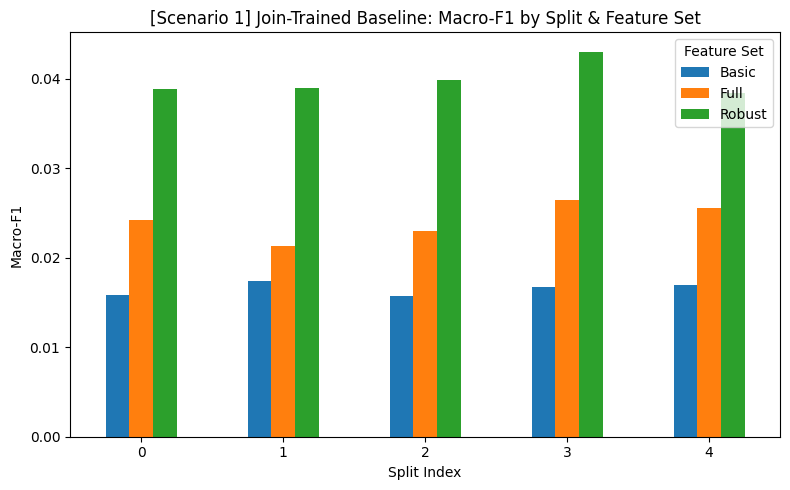

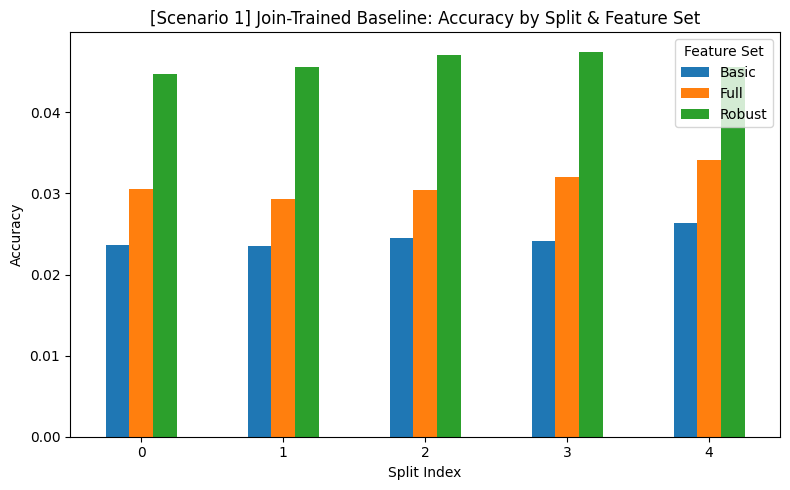

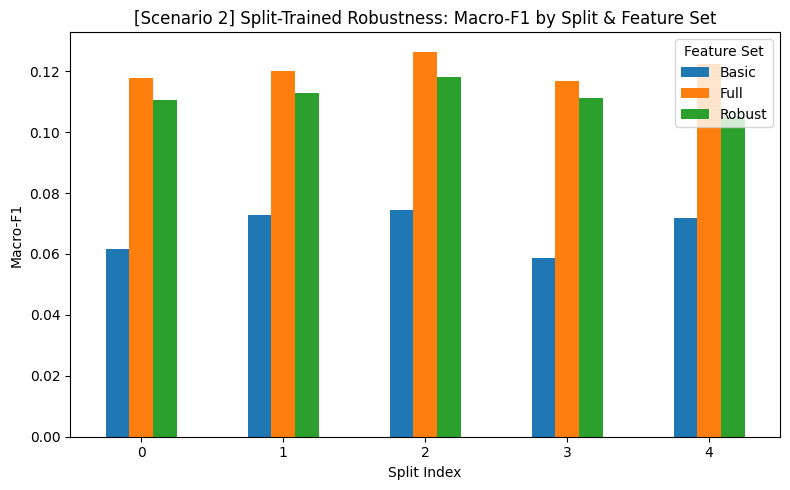

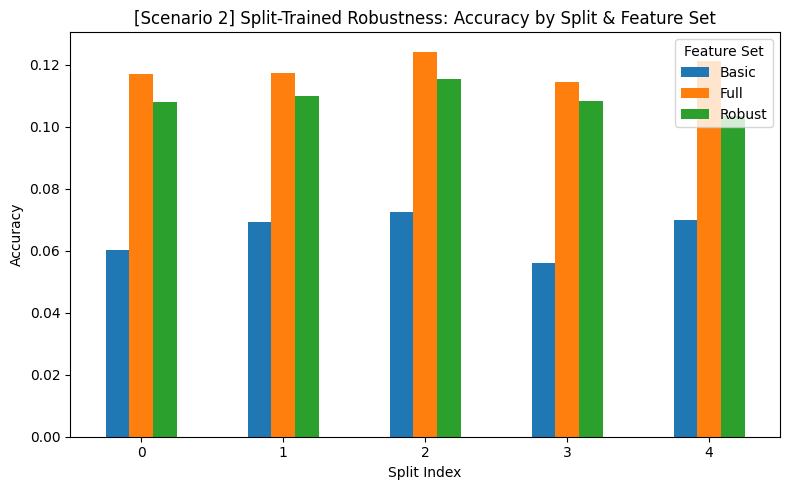

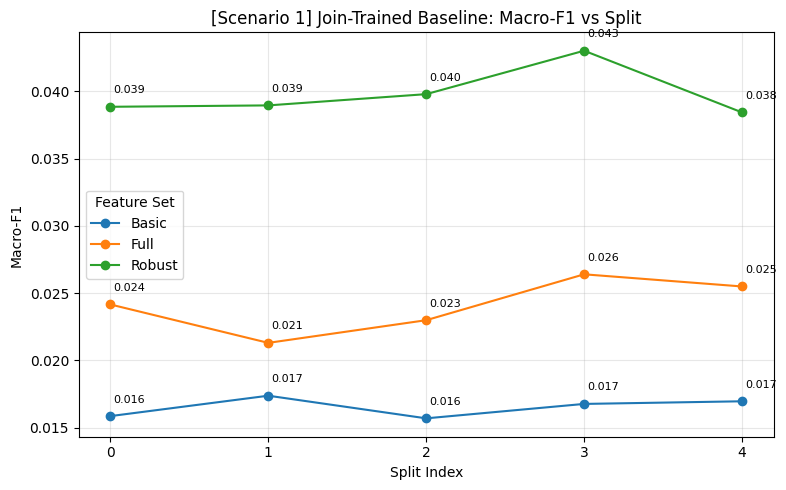

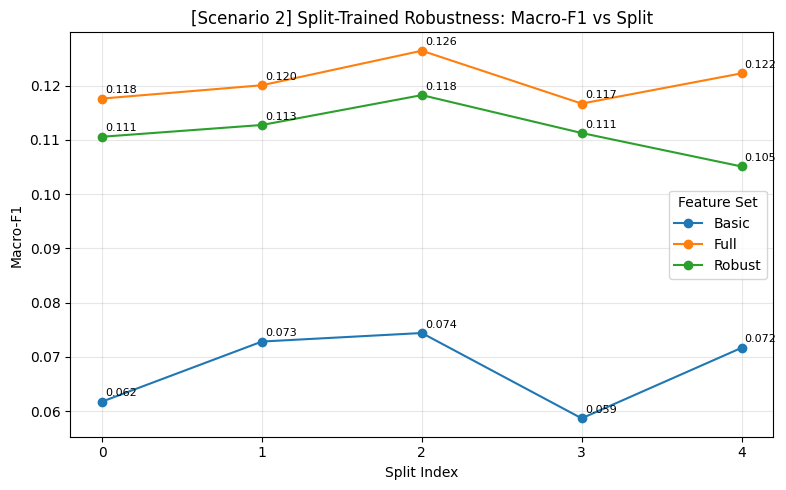

In [ ]:
# bar plot
df_join_all, df_split_all = plot_feature_set_comparison(
    df_s1_full, df_s2_full,
    df_s1_robust, df_s2_robust,
    df_s1_basic, df_s2_basic,
)

# line plot
df_join_all, df_split_all = build_join_split_tables(
    df_s1_full, df_s2_full,
    df_s1_robust, df_s2_robust,
    df_s1_basic, df_s2_basic
)
plot_macro_f1_lines(df_join_all, df_split_all)

## Open-binary

In [ ]:
XGB_BEST_PARAMS_OPEN_BINARY = {
    "tree_method": "hist",
    "subsample": 0.7,
    "random_state": 42,
    "n_estimators": 500,
    "min_child_weight": 1,
    "max_depth": 4,
    "learning_rate": 0.1,
    "eval_metric": "mlogloss",
    "device": "cuda",
    "colsample_bytree": 0.8
}

models_to_open_binary = [
    (XGBClassifier, XGB_BEST_PARAMS_OPEN_BINARY, 'XGB')
]

### 1.run scenarios

In [ ]:
# =================================================================
# [Scenario 1] Join -> Split_i (Train: Join / Test: Split_i)
# =================================================================

def prepare_binary_join_to_split_val(mon_dict, unmon_dict, split_idx):
    """Auto-Threshold용: Join(Tr/Val) -> Split_i(Test)"""
    # 1. Train Source: Join
    X_src = mon_dict['X_join'].copy()
    y_src = mon_dict['y_join'].copy()

    # 2. Test Source: Split_i
    key_X_test = f'X_split_{split_idx}'
    X_test_src = mon_dict[key_X_test].copy()

    # Unmonitored (Validation용 & Test용)
    if unmon_dict and key_X_test in unmon_dict:
        X_unmon = unmon_dict[key_X_test].copy()
    else:
        X_unmon = pd.DataFrame()

    # 공통 컬럼
    common_cols = [c for c in X_src.columns if c in X_test_src.columns]
    if not X_unmon.empty:
        common_cols = [c for c in common_cols if c in X_unmon.columns]

    X_src = X_src[common_cols]
    X_test_src = X_test_src[common_cols]
    if not X_unmon.empty:
        X_unmon = X_unmon[common_cols]

    # --- Split ---
    # Train(Join) -> Train/Val
    X_train, X_val_mon, y_train, y_val_mon = train_test_split(
        X_src, y_src, test_size=0.25, random_state=42, stratify=y_src
    )

    # Unmon -> Val/Test
    if len(X_unmon) > 0:
        X_val_unmon, X_test_unmon = train_test_split(X_unmon, test_size=0.5, random_state=42)
    else:
        X_val_unmon, X_test_unmon = pd.DataFrame(), pd.DataFrame()

    # Validation Set (Mixed)
    X_val_final = pd.concat([X_val_mon, X_val_unmon], axis=0)
    y_val_bin = np.concatenate([np.ones(len(X_val_mon)), np.zeros(len(X_val_unmon))])

    # Test Set (Mixed: Split_i 전체 Mon + Unmon 절반)
    X_test_final = pd.concat([X_test_src, X_test_unmon], axis=0)
    y_test_bin = np.concatenate([np.ones(len(X_test_src)), np.zeros(len(X_test_unmon))])

    return X_train, y_train, X_val_final, y_val_bin, X_test_final, y_test_bin


def prepare_binary_join_to_split_no_val(mon_dict, unmon_dict, split_idx):
    """Fixed Eval용: Join(Full) -> Split_i(Full)"""
    X_train = mon_dict['X_join'].copy()
    y_train = mon_dict['y_join'].copy()

    key_X_test = f'X_split_{split_idx}'
    X_test_mon = mon_dict[key_X_test].copy()

    if unmon_dict and key_X_test in unmon_dict:
        X_test_unmon = unmon_dict[key_X_test].copy()
    else:
        X_test_unmon = pd.DataFrame()

    # 컬럼 매칭
    common_cols = [c for c in X_train.columns if c in X_test_mon.columns]
    if not X_test_unmon.empty:
        common_cols = [c for c in common_cols if c in X_test_unmon.columns]

    X_train = X_train[common_cols]

    X_test_final = pd.concat([X_test_mon[common_cols], X_test_unmon[common_cols]], axis=0)
    y_test_bin = np.concatenate([np.ones(len(X_test_mon)), np.zeros(len(X_test_unmon))])

    return X_train, y_train, X_test_final, y_test_bin


# =================================================================
# [Scenario 2] Split_i -> Split_i (Train: Split_i / Test: Split_i)
# =================================================================

def prepare_binary_split_to_split_val(mon_dict, unmon_dict, split_idx):
    """Auto-Threshold용: Split_i 내부 분할 (Tr/Val/Te)"""
    key_X = f'X_split_{split_idx}'
    key_y = f'y_split_{split_idx}'

    X_mon = mon_dict[key_X].copy()
    y_mon = mon_dict[key_y].copy()

    if unmon_dict and key_X in unmon_dict:
        X_unmon = unmon_dict[key_X].copy()
    else:
        X_unmon = pd.DataFrame()

    if not X_unmon.empty:
        common_cols = [c for c in X_mon.columns if c in X_unmon.columns]
        X_mon = X_mon[common_cols]
        X_unmon = X_unmon[common_cols]

    # Mon Split: Train(60)/Val(20)/Test(20)
    X_tr_val, X_te_mon, y_tr_val, y_te_mon = train_test_split(
        X_mon, y_mon, test_size=0.2, random_state=42, stratify=y_mon
    )
    X_tr, X_val_mon, y_tr, y_val_mon = train_test_split(
        X_tr_val, y_tr_val, test_size=0.25, random_state=42, stratify=y_tr_val
    )

    # Unmon Split: Val(50)/Test(50)
    if len(X_unmon) > 0:
        X_val_unmon, X_te_unmon = train_test_split(X_unmon, test_size=0.5, random_state=42)
    else:
        X_val_unmon, X_te_unmon = pd.DataFrame(), pd.DataFrame()

    X_val_final = pd.concat([X_val_mon, X_val_unmon], axis=0)
    y_val_bin = np.concatenate([np.ones(len(X_val_mon)), np.zeros(len(X_val_unmon))])

    X_te_final = pd.concat([X_te_mon, X_te_unmon], axis=0)
    y_te_bin = np.concatenate([np.ones(len(X_te_mon)), np.zeros(len(X_te_unmon))])

    return X_tr, y_tr, X_val_final, y_val_bin, X_te_final, y_te_bin


def prepare_binary_split_to_split_no_val(mon_dict, unmon_dict, split_idx):
    """Fixed Eval용: Split_i 내부 분할 (Tr/Te)"""
    key_X = f'X_split_{split_idx}'
    key_y = f'y_split_{split_idx}'

    X_mon = mon_dict[key_X].copy()
    y_mon = mon_dict[key_y].copy()

    if unmon_dict and key_X in unmon_dict:
        X_unmon = unmon_dict[key_X].copy()
    else:
        X_unmon = pd.DataFrame()

    if not X_unmon.empty:
        common_cols = [c for c in X_mon.columns if c in X_unmon.columns]
        X_mon = X_mon[common_cols]
        X_unmon = X_unmon[common_cols]

    # Mon: Train(80)/Test(20)
    X_tr, X_te_mon, y_tr, y_te_mon = train_test_split(
        X_mon, y_mon, test_size=0.2, random_state=42, stratify=y_mon
    )

    # Unmon: 전체 Test
    X_te_final = pd.concat([X_te_mon, X_unmon], axis=0)
    y_te_bin = np.concatenate([np.ones(len(X_te_mon)), np.zeros(len(X_unmon))])

    return X_tr, y_tr, X_te_final, y_te_bin


# =================================================================
# Auto Threshold Pipeline
# =================================================================
def run_auto_threshold_binary_all(mon_dict, unmon_dict, models_list):
    results = []

    # 1. Join -> Split_i (0~4)
    print("\n[Auto-Threshold] Scenario: Join -> Split_i")
    for i in range(5):
        X_tr, y_tr, X_val, y_val, X_te, y_te_bin = prepare_binary_join_to_split_val(
            mon_dict, unmon_dict, i
        )

        le = LabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)

        for model_class, params, name in models_list:
            curr = params.copy()
            if name == 'XGB':
                curr['objective'] = 'multi:softprob'
                curr['num_class'] = len(np.unique(y_tr_enc))

            model = model_class(**curr, n_jobs=-1)
            model.fit(X_tr, y_tr_enc)

            # 최적 Threshold 찾기
            res = find_best_threshold_and_evaluate(model, X_val, y_val, X_te, y_te_bin)
            res['Model'] = name
            res['Scenario'] = f'Join→Split_{i}'
            results.append(res)

            # 전체 지표 출력
            print(
                f"  {res['Scenario']} | {name} | "
                f"Th*: {res['Best_Threshold']:.2f} | "
                f"Macro F1: {res['F1_OpenSet']:.4f} | "
                f"Acc: {res['overall_acc']:.4f} | "
                f"TPR: {res['TPR']:.4f} | TNR: {res['TNR']:.4f} | "
                f"FPR: {res['FPR']:.4f} | Precision: {res['Precision']:.4f} | "
                f"ROC-AUC: {res['ROC_AUC']:.4f}"
            )

    # 2. Split_i -> Split_i (0~4)
    print("\n[Auto-Threshold] Scenario: Split_i -> Split_i")
    for i in range(5):
        X_tr, y_tr, X_val, y_val, X_te, y_te_bin = prepare_binary_split_to_split_val(
            mon_dict, unmon_dict, i
        )

        le = LabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)

        for model_class, params, name in models_list:
            curr = params.copy()
            if name == 'XGB':
                curr['objective'] = 'multi:softprob'
                curr['num_class'] = len(np.unique(y_tr_enc))

            model = model_class(**curr, n_jobs=-1)
            model.fit(X_tr, y_tr_enc)

            res = find_best_threshold_and_evaluate(model, X_val, y_val, X_te, y_te_bin)
            res['Model'] = name
            res['Scenario'] = f'Split_{i}→Split_{i}'
            results.append(res)

            print(
                f"  {res['Scenario']} | {name} | "
                f"Th*: {res['Best_Threshold']:.2f} | "
                f"Macro F1: {res['F1_OpenSet']:.4f} | "
                f"Acc: {res['overall_acc']:.4f} | "
                f"TPR: {res['TPR']:.4f} | TNR: {res['TNR']:.4f} | "
                f"FPR: {res['FPR']:.4f} | Precision: {res['Precision']:.4f} | "
                f"ROC-AUC: {res['ROC_AUC']:.4f}"
            )

    return pd.DataFrame(results)


# =================================================================
# Fixed Threshold Pipeline
# =================================================================
def run_fixed_threshold_binary_all(mon_dict, unmon_dict, models_list, scenario_thresholds):
    results = []

    # 1. Join -> Split_i
    print("\n[Fixed-Threshold] Scenario: Join -> Split_i")
    for i in range(5):
        scenario_name = f'Join→Split_{i}'
        th = scenario_thresholds.get(scenario_name, 0.5)

        X_tr, y_tr, X_te, y_te_bin = prepare_binary_join_to_split_no_val(
            mon_dict, unmon_dict, i
        )
        le = LabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)

        for model_class, params, name in models_list:
            curr = params.copy()
            if name == 'XGB':
                curr['objective'] = 'multi:softprob'
                curr['num_class'] = len(np.unique(y_tr_enc))

            model = model_class(**curr, n_jobs=-1)
            model.fit(X_tr, y_tr_enc)

            res = evaluate_with_fixed_threshold(model, X_te, y_te_bin, threshold=th)
            res['Model'] = name
            res['Scenario'] = scenario_name
            results.append(res)

            print(
                f"  {res['Scenario']} | {name} | "
                f"Th: {res['Threshold']:.2f} | "
                f"Macro F1: {res['F1_OpenSet']:.4f} | "
                f"Acc: {res['overall_acc']:.4f} | "
                f"TPR: {res['TPR']:.4f} | TNR: {res['TNR']:.4f} | "
                f"FPR: {res['FPR']:.4f} | Precision: {res['Precision']:.4f} | "
                f"ROC-AUC: {res['ROC_AUC']:.4f}"
            )

    # 2. Split_i -> Split_i
    print("\n[Fixed-Threshold] Scenario: Split_i -> Split_i")
    for i in range(5):
        scenario_name = f'Split_{i}→Split_{i}'
        th = scenario_thresholds.get(scenario_name, 0.5)

        X_tr, y_tr, X_te, y_te_bin = prepare_binary_split_to_split_no_val(
            mon_dict, unmon_dict, i
        )
        le = LabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)

        for model_class, params, name in models_list:
            curr = params.copy()
            if name == 'XGB':
                curr['objective'] = 'multi:softprob'
                curr['num_class'] = len(np.unique(y_tr_enc))

            model = model_class(**curr, n_jobs=-1)
            model.fit(X_tr, y_tr_enc)

            res = evaluate_with_fixed_threshold(model, X_te, y_te_bin, threshold=th)
            res['Model'] = name
            res['Scenario'] = scenario_name
            results.append(res)

            print(
                f"  {res['Scenario']} | {name} | "
                f"Th: {res['Threshold']:.2f} | "
                f"Macro F1: {res['F1_OpenSet']:.4f} | "
                f"Acc: {res['overall_acc']:.4f} | "
                f"TPR: {res['TPR']:.4f} | TNR: {res['TNR']:.4f} | "
                f"FPR: {res['FPR']:.4f} | Precision: {res['Precision']:.4f} | "
                f"ROC-AUC: {res['ROC_AUC']:.4f}"
            )

    return pd.DataFrame(results)


In [ ]:
# 1. Auto-Threshold 실행 (Best Threshold 찾기)
df_auto_full = run_auto_threshold_binary_all(mon_data_full, unmon_data_full, models_to_open_binary)
df_auto_full['Feature_Set'] = 'Full'

df_auto_robust = run_auto_threshold_binary_all(mon_data_robust, unmon_data_robust, models_to_open_binary)
df_auto_robust['Feature_Set'] = 'Robust'

df_auto_basic = run_auto_threshold_binary_all(mon_data_basic, unmon_data_basic, models_to_open_binary)
df_auto_basic['Feature_Set'] = 'Basic'


# Threshold Dictionary 생성
th_full = dict(zip(df_auto_full['Scenario'], df_auto_full['Best_Threshold']))
th_robust = dict(zip(df_auto_robust['Scenario'], df_auto_robust['Best_Threshold']))
th_basic = dict(zip(df_auto_basic['Scenario'], df_auto_basic['Best_Threshold']))


# 2. Fixed Pipeline 실행 (찾은 Threshold로 전체 데이터 평가)
df_fixed_full = run_fixed_threshold_binary_all(mon_data_full, unmon_data_full, models_to_open_binary, th_full)
df_fixed_full['Feature_Set'] = 'Full'

df_fixed_robust = run_fixed_threshold_binary_all(mon_data_robust, unmon_data_robust, models_to_open_binary, th_robust)
df_fixed_robust['Feature_Set'] = 'Robust'

df_fixed_basic = run_fixed_threshold_binary_all(mon_data_basic, unmon_data_basic, models_to_open_binary, th_basic)
df_fixed_basic['Feature_Set'] = 'Basic'


# 데이터 통합
df_binary_all = pd.concat([df_fixed_full, df_fixed_robust, df_fixed_basic], ignore_index=True)


# 시나리오 순서 및 타입 정의
scenario_order = [f'Join→Split_{i}' for i in range(5)] + [f'Split_{i}→Split_{i}' for i in range(5)]
df_binary_all['Scenario'] = pd.Categorical(df_binary_all['Scenario'], categories=scenario_order, ordered=True)
df_binary_all['Scenario_Type'] = df_binary_all['Scenario'].apply(lambda x: 'Join→Split' if 'Join' in x else 'Split→Split')




[Auto-Threshold] Scenario: Join -> Split_i
  Join→Split_0 | XGB | Th*: 0.94 | Macro F1: 0.4345 | Acc: 0.4614 | TPR: 0.4235 | TNR: 0.6153 | FPR: 0.3847 | Precision: 0.8171 | ROC-AUC: 0.5192
  Join→Split_1 | XGB | Th*: 0.91 | Macro F1: 0.4468 | Acc: 0.4848 | TPR: 0.4667 | TNR: 0.5575 | FPR: 0.4425 | Precision: 0.8087 | ROC-AUC: 0.5136
  Join→Split_2 | XGB | Th*: 0.97 | Macro F1: 0.3764 | Acc: 0.3826 | TPR: 0.3005 | TNR: 0.7162 | FPR: 0.2838 | Precision: 0.8116 | ROC-AUC: 0.5226
  Join→Split_3 | XGB | Th*: 0.97 | Macro F1: 0.3803 | Acc: 0.3868 | TPR: 0.3043 | TNR: 0.7243 | FPR: 0.2757 | Precision: 0.8188 | ROC-AUC: 0.5204
  Join→Split_4 | XGB | Th*: 0.85 | Macro F1: 0.4820 | Acc: 0.5391 | TPR: 0.5425 | TNR: 0.5253 | FPR: 0.4747 | Precision: 0.8231 | ROC-AUC: 0.5393

[Auto-Threshold] Scenario: Split_i -> Split_i
  Split_0→Split_0 | XGB | Th*: 0.37 | Macro F1: 0.4953 | Acc: 0.5267 | TPR: 0.3096 | TNR: 0.7030 | FPR: 0.2970 | Precision: 0.4584 | ROC-AUC: 0.5049
  Split_1→Split_1 | XGB | Th*:

### 2. visualization

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_open_binary_all(df_full, df_robust, df_basic, title_suffix="(Auto Th)"):
    """
    df_* 는 모두 binary open-world 결과 DataFrame:
      - 컬럼: ['Scenario', 'F1_OpenSet', 'overall_acc', 'FPR', 'TPR', 'ROC_AUC', ...]
      - run_auto_threshold_binary_all() 또는 run_fixed_threshold_binary_all() 결과 사용

    예)
      plot_open_binary_all(df_auto_full, df_auto_robust, df_auto_basic, "(Auto Th)")
      plot_open_binary_all(df_fix_full, df_fix_robust, df_fix_basic, "(Fixed Th)")
    """

    # ==========================================================
    # [1] 데이터 통합 (3개 Feature Set 합치기)
    # ==========================================================
    df_full  = df_full.copy()
    df_robust = df_robust.copy()
    df_basic  = df_basic.copy()

    df_full['Feature_Set']   = 'Full'
    df_robust['Feature_Set'] = 'Robust'
    df_basic['Feature_Set']  = 'Basic'

    df_all = pd.concat([df_full, df_robust, df_basic], ignore_index=True)

    # 시나리오 종류 구분 (Join→Split vs Split→Split)
    df_all['Scenario_Type'] = df_all['Scenario'].apply(
        lambda x: 'Join→Split' if 'Join' in x else 'Split→Split'
    )

    # Scenario 순서 정렬
    scenario_order = [f'Join→Split_{i}' for i in range(5)] + [f'Split_{i}→Split_{i}' for i in range(5)]
    df_all['Scenario'] = pd.Categorical(
        df_all['Scenario'], categories=scenario_order, ordered=True
    )

    # ==========================================================
    # [2] F1 & Accuracy Bar Plot
    # ==========================================================
    f1_acc = df_all.groupby(
        ['Scenario', 'Feature_Set']
    )[["F1_OpenSet", "overall_acc"]].mean().reset_index()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

    # (a) F1_OpenSet
    pivot_f1 = f1_acc.pivot(index='Scenario', columns='Feature_Set', values='F1_OpenSet')
    pivot_f1.plot(kind='bar', ax=axes[0])
    axes[0].set_title(f'Open Binary Macro F1 by Scenario & Feature Set {title_suffix}')
    axes[0].set_ylabel('Macro F1 (Open-Set)')
    axes[0].set_xlabel('Scenario')
    axes[0].tick_params(axis='x', rotation=45)

    # (b) overall_acc
    pivot_acc = f1_acc.pivot(index='Scenario', columns='Feature_Set', values='overall_acc')
    pivot_acc.plot(kind='bar', ax=axes[1])
    axes[1].set_title(f'Open Binary Accuracy by Scenario & Feature Set {title_suffix}')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Scenario')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # [3] ROC-AUC by Scenario
    # ==========================================================
    plt.figure(figsize=(10, 5))
    for fs in df_all['Feature_Set'].unique():
        sub = df_all[df_all['Feature_Set'] == fs].sort_values('Scenario')
        plt.plot(sub['Scenario'], sub['ROC_AUC'],
                 marker='o', label=fs)

    # baseline 0.5
    plt.axhline(0.5, linestyle='--', color='gray')
    plt.title(f'Open Binary ROC-AUC by Scenario & Feature Set {title_suffix}')
    plt.xlabel('Scenario')
    plt.ylabel('ROC-AUC')
    plt.legend(title='Feature Set')
    plt.xticks(rotation=45)

    # 변화가 잘 보이도록 y축 살짝 줌 (필요에 따라 조절)
    ymin = max(0.45, df_all['ROC_AUC'].min() - 0.02)
    ymax = min(0.65, df_all['ROC_AUC'].max() + 0.02)
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # [4] TPR vs FPR
    # ==========================================================
    plt.figure(figsize=(7, 7))
    for fs in df_all['Feature_Set'].unique():
        sub = df_all[df_all['Feature_Set'] == fs]
        plt.scatter(sub['FPR'], sub['TPR'], label=fs, alpha=0.7)

        # 시나리오 이름의 뒷부분만 텍스트로 표시 (Split_0, Split_1 ...)
        for _, row in sub.iterrows():
            plt.text(row['FPR'] + 0.005, row['TPR'] + 0.005,
                     row['Scenario'].split('→')[-1],
                     fontsize=7)

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title(f'TPR vs FPR (All Scenarios) {title_suffix}')
    plt.legend(title='Feature Set')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # ==========================================================
    # [5] Join→Split vs Split→Split 비교 (TPR vs FPR)
    # ==========================================================
    plt.figure(figsize=(8, 6))

    for stype in ['Join→Split', 'Split→Split']:
        sub = df_all[df_all['Scenario_Type'] == stype]
        plt.scatter(sub['FPR'], sub['TPR'],
                    label=stype, s=120, marker='*')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'TPR vs FPR: Join→Split vs Split→Split {title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ==========================================================
    # [6] F1_OpenSet 비교 (Join→Split vs Split→Split)
    # ==========================================================
    f1_summary = df_all.groupby(
        ['Scenario_Type', 'Feature_Set']
    )['F1_OpenSet'].mean().reset_index()

    ax = f1_summary.pivot(
        index='Feature_Set',
        columns='Scenario_Type',
        values='F1_OpenSet'
    ).plot(kind='bar', figsize=(7, 5))

    ax.set_title(f'Macro F1 Comparison: Join→Split vs Split→Split {title_suffix}')
    ax.set_ylabel('Macro F1 (Open-Set)')
    ax.set_xlabel('Feature Set')
    plt.tight_layout()
    plt.show()


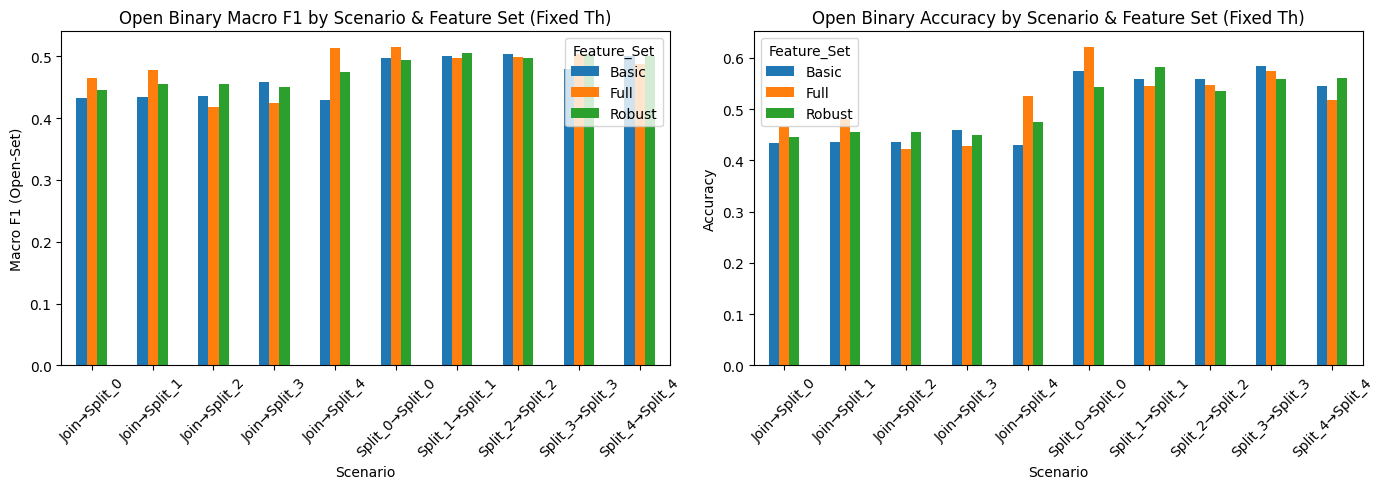

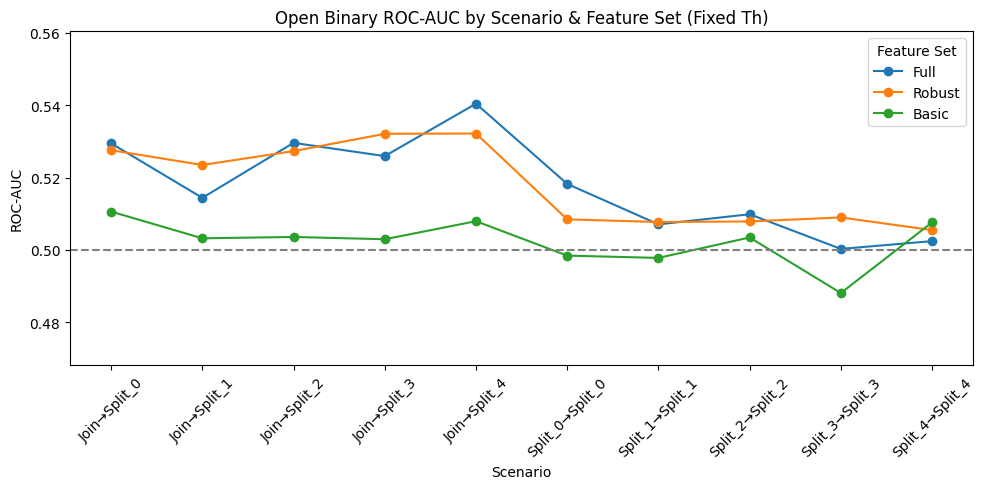

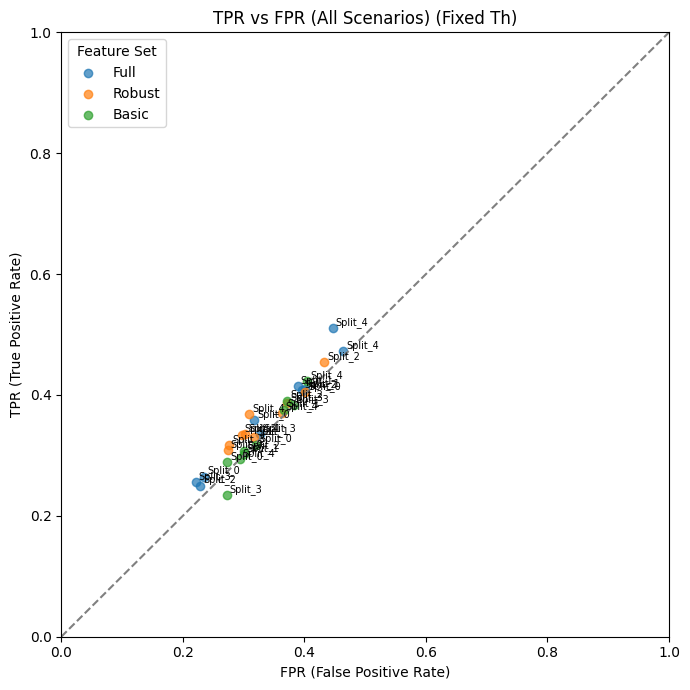

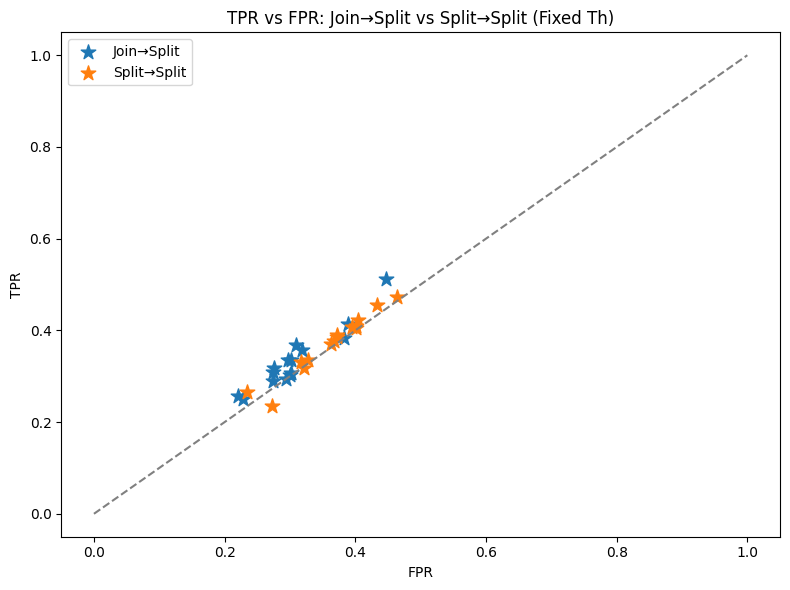

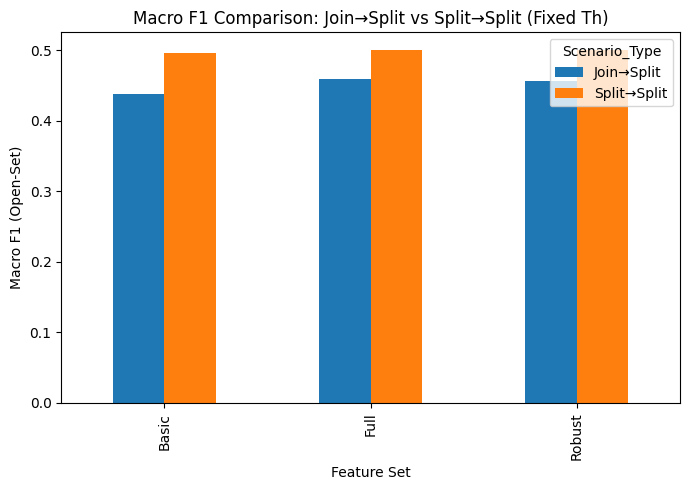

In [ ]:
plot_open_binary_all(df_fixed_full, df_fixed_robust, df_fixed_basic, title_suffix="(Fixed Th)")

## Open-Multi

In [ ]:
XGB_BEST_PARAMS_OPEN_MULTI = {
    "tree_method": "hist",
    "subsample": 0.8,
    "random_state": 42,
    "n_estimators": 500,
    "min_child_weight": 1,
    "max_depth": 4,
    "learning_rate": 0.1,
    "eval_metric": "mlogloss",
    "device": "cuda",
    "colsample_bytree": 0.7
}

models_to_open_multi = [
    (XGBClassifier, XGB_BEST_PARAMS_OPEN_MULTI, 'XGB')
]

### 1.run scenarios

In [ ]:
def prepare_open_multi_join_to_split(mon_dict, unmon_dict, split_idx):
    """
    [Join→Split 평가]
    - 학습: join (Monitored)
    - 테스트: split_i (Monitored + Unmonitored)
    """
    # Join 학습 데이터
    X_train = mon_dict['X_join'].copy()
    y_train = mon_dict['y_join'].copy()

    # Split 테스트 데이터
    key_X = f'X_split_{split_idx}'
    key_y = f'y_split_{split_idx}'

    X_test_mon = mon_dict[key_X].copy()
    y_test_mon = mon_dict[key_y].copy()

    # Unmonitored split_i (있을 수도 없을 수도 있음)
    if unmon_dict and key_X in unmon_dict:
        X_test_unmon = unmon_dict[key_X].copy()
    else:
        X_test_unmon = pd.DataFrame()

    # Feature 공통화
    if not X_test_unmon.empty:
        common_cols = [c for c in X_train.columns if c in X_test_unmon.columns]
        X_train = X_train[common_cols].copy()
        X_test_mon = X_test_mon[common_cols].copy()
        X_test_unmon = X_test_unmon[common_cols].copy()
    else:
        common_cols = X_train.columns
        X_test_mon = X_test_mon[common_cols].copy()

    # Open-world binary + class labels 생성
    X_test_final = pd.concat([X_test_mon, X_test_unmon], axis=0)
    y_test_bin = np.concatenate([
        np.ones(len(X_test_mon)),   # Monitored
        np.zeros(len(X_test_unmon)) # Unmonitored
    ])
    y_test_class = np.concatenate([
        y_test_mon.values,
        [-1]*len(X_test_unmon)
    ])

    return X_train, y_train, X_test_final, y_test_bin, y_test_class
def prepare_open_multi_split_to_split(mon_dict, unmon_dict, split_idx, test_size=0.2):
    """
    [Split→Split 평가]
    - 학습: split_i (Monitored 80%)
    - 테스트: split_i의 나머지 20% + 해당 split_i의 Unmonitored
    """
    key_X = f'X_split_{split_idx}'
    key_y = f'y_split_{split_idx}'

    X_mon = mon_dict[key_X].copy()
    y_mon = mon_dict[key_y].copy()

    # Unmonitored
    if unmon_dict and key_X in unmon_dict:
        X_unmon = unmon_dict[key_X].copy()
    else:
        X_unmon = pd.DataFrame()

    # 공통 feature
    if not X_unmon.empty:
        common_cols = [c for c in X_mon.columns if c in X_unmon.columns]
        X_mon = X_mon[common_cols]
        X_unmon = X_unmon[common_cols]

    # Split 학습/테스트 분할
    X_train, X_test_mon, y_train, y_test_mon = train_test_split(
        X_mon, y_mon, test_size=test_size, stratify=y_mon, random_state=42
    )

    X_test_final = pd.concat([X_test_mon, X_unmon], axis=0)
    y_test_bin = np.concatenate([
        np.ones(len(X_test_mon)),
        np.zeros(len(X_unmon))
    ])
    y_test_class = np.concatenate([
        y_test_mon.values,
        [-1]*len(X_unmon)
    ])

    return X_train, y_train, X_test_final, y_test_bin, y_test_class


In [ ]:
def evaluate_open_multi(model, X_test, y_test_bin, y_test_class, threshold=0.5):
    """
    Threshold-based open-world multi-class 평가
    """
    probs = model.predict_proba(X_test)
    max_conf = np.max(probs, axis=1)
    pred_class = np.argmax(probs, axis=1)

    # Detection
    y_pred_bin = (max_conf >= threshold).astype(int)
    pred_class_open = pred_class.copy()
    pred_class_open[y_pred_bin == 0] = -1  # Unknown 처리

    # Binary metrics
    tn, fp, fn, tp = confusion_matrix(y_test_bin, y_pred_bin).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    acc_bin = accuracy_score(y_test_bin, y_pred_bin)
    f1_bin = f1_score(y_test_bin, y_pred_bin, average='macro')
    precision_bin = precision_score(y_test_bin, y_pred_bin, zero_division=0)

    try:
        roc_auc = roc_auc_score(y_test_bin, max_conf)
    except ValueError:
        roc_auc = np.nan

    # Classification (Monitored only)
    mask_mon = (y_test_class != -1)
    y_true_mon = y_test_class[mask_mon]
    y_pred_mon = pred_class_open[mask_mon]

    class_acc = accuracy_score(y_true_mon, y_pred_mon)
    class_f1 = f1_score(y_true_mon, y_pred_mon, average='macro')

    return {
        'Threshold': threshold,
        'Detection_F1': f1_bin,
        'Detection_TPR': tpr,
        'Detection_FPR': fpr,
        'Detection_TNR': tnr,
        'Detection_Acc': acc_bin,
        'Detection_Precision': precision_bin,
        'Detection_ROC_AUC': roc_auc,
        'Class_Acc': class_acc,
        'Class_F1': class_f1
    }
def run_open_multi_join_to_split(mon_dict, unmon_dict, models_list, thresholds=[0.15, 0.2, 0.25, 0.3]):
    """
    [Scenario 1] Join→Split_i Open-world Multi Evaluation
    """
    results = []

    for split_idx in range(5):
        X_tr, y_tr, X_te, y_te_bin, y_te_class = prepare_open_multi_join_to_split(
            mon_dict, unmon_dict, split_idx
        )

        le = LabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)

        for model_class, params, name in models_list:
            curr_params = params.copy()
            if name == 'XGB':
                curr_params['objective'] = 'multi:softprob'
                curr_params['eval_metric'] = 'mlogloss'
                curr_params['num_class'] = len(np.unique(y_tr_enc))

            model = model_class(**curr_params, n_jobs=-1)
            model.fit(X_tr, y_tr_enc)

            for th in thresholds:
                res = evaluate_open_multi(model, X_te, y_te_bin, y_te_class, th)
                res['Scenario'] = f'Join→Split_{split_idx}'
                res['Model'] = name
                res['Threshold'] = th
                results.append(res)

    return pd.DataFrame(results)
def run_open_multi_split_to_split(mon_dict, unmon_dict, models_list, thresholds=[0.15, 0.2, 0.25, 0.3]):
    """
    [Scenario 2] Split_i→Split_i Open-world Multi Evaluation
    """
    results = []

    for split_idx in range(5):
        X_tr, y_tr, X_te, y_te_bin, y_te_class = prepare_open_multi_split_to_split(
            mon_dict, unmon_dict, split_idx
        )

        le = LabelEncoder()
        y_tr_enc = le.fit_transform(y_tr)

        for model_class, params, name in models_list:
            curr_params = params.copy()
            if name == 'XGB':
                curr_params['objective'] = 'multi:softprob'
                curr_params['eval_metric'] = 'mlogloss'
                curr_params['num_class'] = len(np.unique(y_tr_enc))

            model = model_class(**curr_params, n_jobs=-1)
            model.fit(X_tr, y_tr_enc)

            for th in thresholds:
                res = evaluate_open_multi(model, X_te, y_te_bin, y_te_class, th)
                res['Scenario'] = f'Split_{split_idx}→Split_{split_idx}'
                res['Model'] = name
                res['Threshold'] = th
                results.append(res)

    return pd.DataFrame(results)


In [ ]:
def run_all_open_multi_scenarios(mon_dict, unmon_dict, models_list):
    """
    Join→Split_i + Split_i→Split_i 시나리오 전체 수행
    """
    print("="*70)
    print(" [Open-Multi] Evaluation Pipeline Start")
    print("="*70)

    df_join_split = run_open_multi_join_to_split(mon_dict, unmon_dict, models_list)
    df_split_split = run_open_multi_split_to_split(mon_dict, unmon_dict, models_list)

    # Binary 버전과 동일한 metric 순서
    cols_to_show = [
        'Detection_F1',
        'Detection_Acc',
        'Detection_Precision',
        'Detection_TPR',
        'Detection_TNR',
        'Detection_FPR',
        'Detection_ROC_AUC',
        'Class_Acc',
        'Class_F1'
    ]

    print("\n[Join→Split] 결과 요약 (Threshold별 평균):")
    print(df_join_split.groupby('Threshold')[cols_to_show].mean().round(4))

    print("\n[Split→Split] 결과 요약 (Threshold별 평균):")
    print(df_split_split.groupby('Threshold')[cols_to_show].mean().round(4))

    print("\n" + "="*70)
    print(" [Open-Multi] Finished all scenarios")
    print("="*70)

    return df_join_split, df_split_split


In [ ]:
# =============================
# Full Feature Set
# =============================
df_om1_full, df_om2_full = run_all_open_multi_scenarios(
    mon_data_full, unmon_data_full, models_to_open_multi
)

# =============================
# Robust Feature Set
# =============================
df_om1_robust, df_om2_robust = run_all_open_multi_scenarios(
    mon_data_robust, unmon_data_robust, models_to_open_multi
)

# =============================
# Basic Feature Set
# =============================
df_om1_basic, df_om2_basic = run_all_open_multi_scenarios(
    mon_data_basic, unmon_data_basic, models_to_open_multi
)


 [Open-Multi] Evaluation Pipeline Start

[Join→Split] 결과 요약 (Threshold별 평균):
           Detection_F1  Detection_Acc  Detection_Precision  Detection_TPR  \
Threshold                                                                    
0.15             0.4018         0.6698               0.6700         0.9994   
0.20             0.4058         0.6679               0.6699         0.9941   
0.25             0.4167         0.6644               0.6703         0.9821   
0.30             0.4328         0.6580               0.6708         0.9613   

           Detection_TNR  Detection_FPR  Detection_ROC_AUC  Class_Acc  \
Threshold                                                               
0.15              0.0007         0.9993             0.5278     0.0323   
0.20              0.0057         0.9943             0.5278     0.0322   
0.25              0.0193         0.9807             0.5278     0.0316   
0.30              0.0423         0.9577             0.5278     0.0307   

           Clas

### 2.visualization


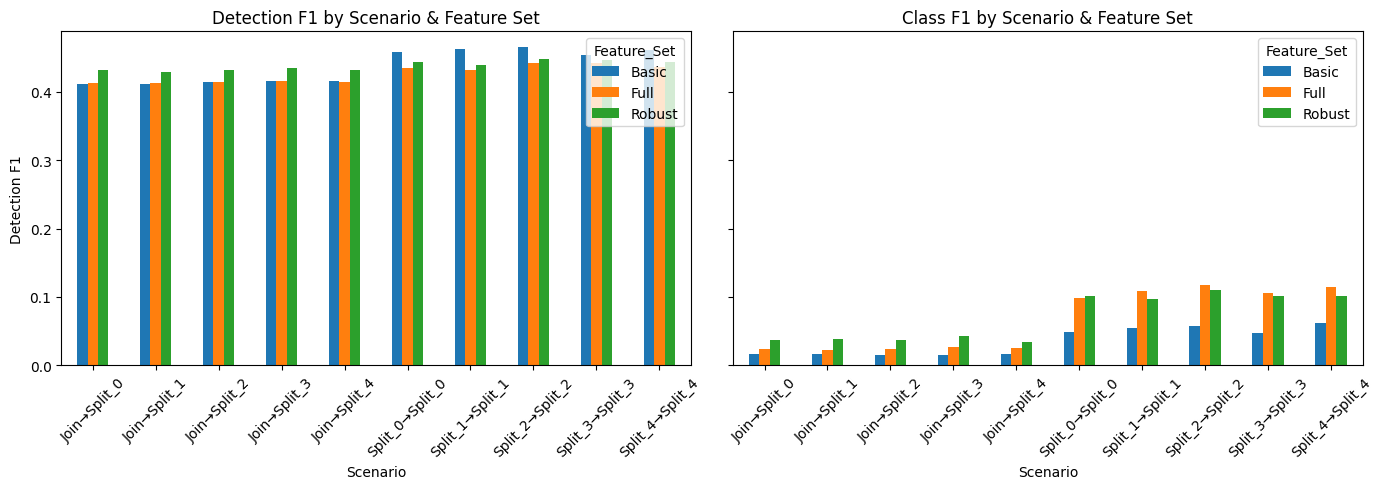

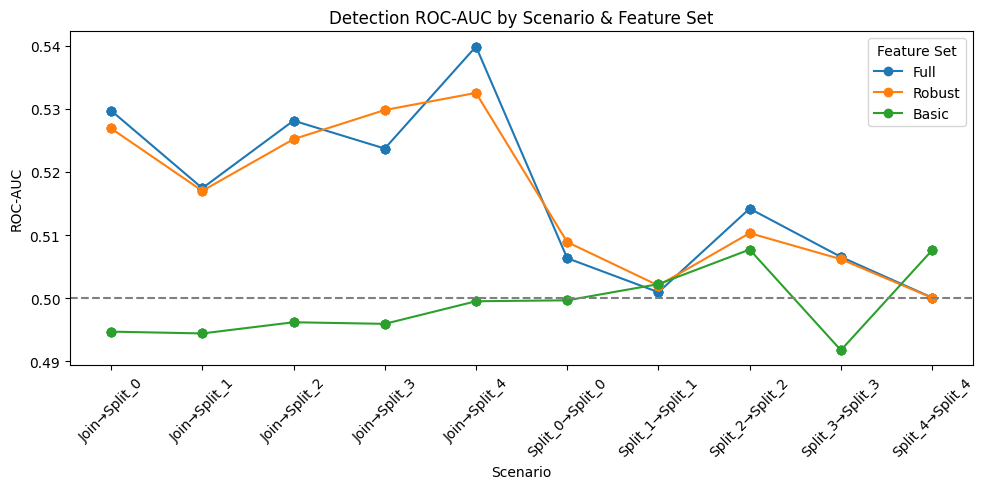

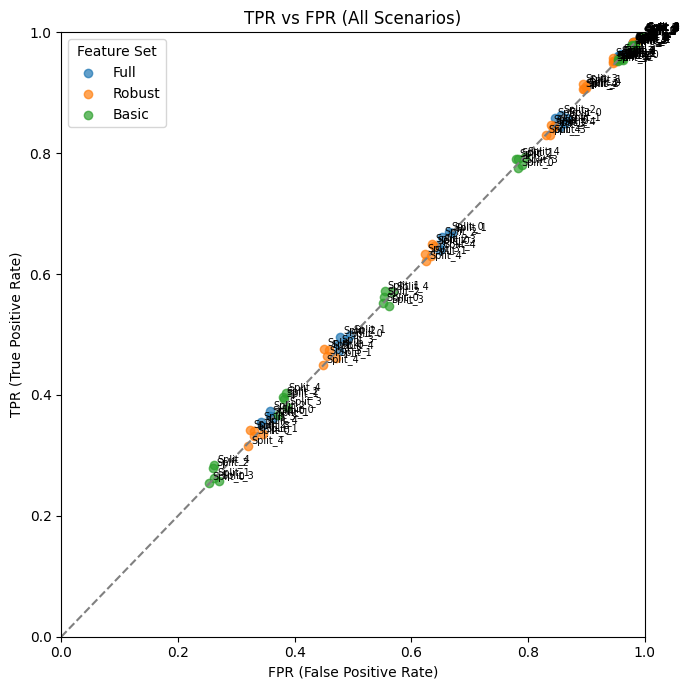

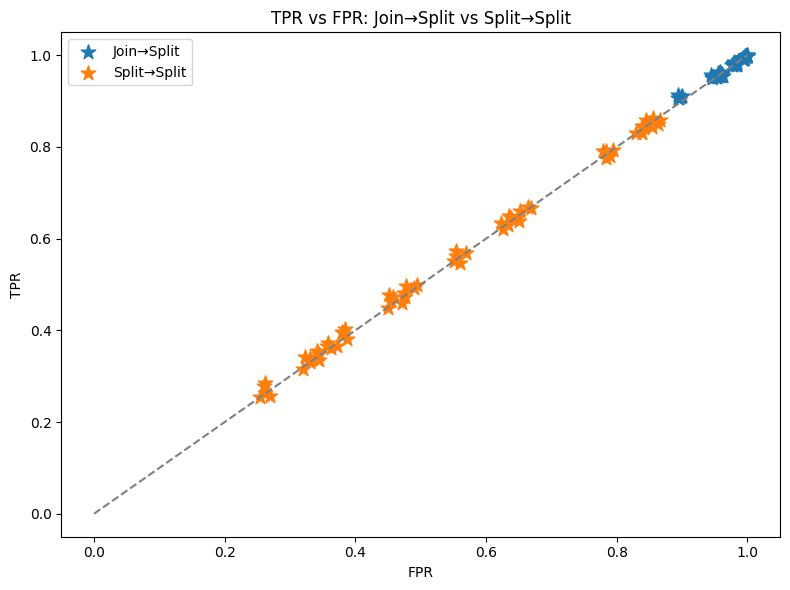

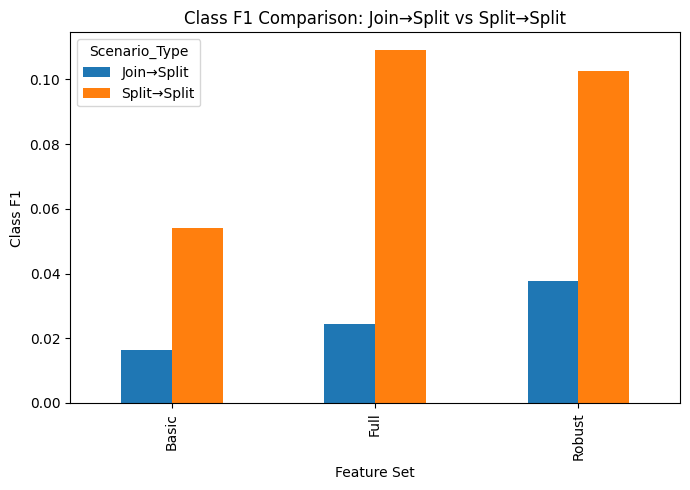

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================================
# [1] 데이터 통합 (Join→Split + Split→Split)
# ==========================================================
df_om1_full['Feature_Set'] = 'Full'
df_om1_robust['Feature_Set'] = 'Robust'
df_om1_basic['Feature_Set'] = 'Basic'

df_om2_full['Feature_Set'] = 'Full'
df_om2_robust['Feature_Set'] = 'Robust'
df_om2_basic['Feature_Set'] = 'Basic'

# 전체 join→split / split→split 합치기
df_open_multi_all = pd.concat([
    df_om1_full, df_om1_robust, df_om1_basic,
    df_om2_full, df_om2_robust, df_om2_basic
], ignore_index=True)

# 시나리오 종류 구분
df_open_multi_all['Scenario_Type'] = df_open_multi_all['Scenario'].apply(
    lambda x: 'Join→Split' if 'Join' in x else 'Split→Split'
)

# Scenario 순서 정렬
scenario_order = [f'Join→Split_{i}' for i in range(5)] + [f'Split_{i}→Split_{i}' for i in range(5)]
df_open_multi_all['Scenario'] = pd.Categorical(
    df_open_multi_all['Scenario'], categories=scenario_order, ordered=True
)

# ==========================================================
# [2] Open-Multi F1 Bar Plot (Detection_F1 vs Class_F1)
# ==========================================================

f1_metrics = df_open_multi_all.groupby(
    ['Scenario', 'Feature_Set']
)[['Detection_F1', 'Class_F1']].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Detection F1
pivot_det = f1_metrics.pivot(index='Scenario', columns='Feature_Set', values='Detection_F1')
pivot_det.plot(kind='bar', ax=axes[0])
axes[0].set_title('Detection F1 by Scenario & Feature Set')
axes[0].set_ylabel('Detection F1')
axes[0].set_xlabel('Scenario')
axes[0].tick_params(axis='x', rotation=45)

# Class F1
pivot_cls = f1_metrics.pivot(index='Scenario', columns='Feature_Set', values='Class_F1')
pivot_cls.plot(kind='bar', ax=axes[1])
axes[1].set_title('Class F1 by Scenario & Feature Set')
axes[1].set_ylabel('Class F1')
axes[1].set_xlabel('Scenario')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# ==========================================================
# [3] Detection ROC-AUC by Scenario
# ==========================================================

plt.figure(figsize=(10, 5))
for fs in df_open_multi_all['Feature_Set'].unique():
    sub = df_open_multi_all[df_open_multi_all['Feature_Set'] == fs]
    plt.plot(sub['Scenario'], sub['Detection_ROC_AUC'],
             marker='o', label=fs)

plt.axhline(0.5, linestyle='--', color='gray')
plt.title('Detection ROC-AUC by Scenario & Feature Set')
plt.xlabel('Scenario')
plt.ylabel('ROC-AUC')
plt.legend(title='Feature Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ==========================================================
# [4] TPR vs FPR (전체 시나리오)
# ==========================================================

plt.figure(figsize=(7, 7))
for fs in df_open_multi_all['Feature_Set'].unique():
    sub = df_open_multi_all[df_open_multi_all['Feature_Set'] == fs]
    plt.scatter(sub['Detection_FPR'], sub['Detection_TPR'], label=fs, alpha=0.7)

    # 라벨 표시 (시나리오 이름)
    for _, row in sub.iterrows():
        plt.text(row['Detection_FPR'] + 0.005, row['Detection_TPR'] + 0.005,
                 row['Scenario'].split('→')[-1], fontsize=7)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('TPR vs FPR (All Scenarios)')
plt.legend(title='Feature Set')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# ==========================================================
# [5] Join→Split vs Split→Split 비교
# ==========================================================

plt.figure(figsize=(8, 6))

for stype in ['Join→Split', 'Split→Split']:
    sub = df_open_multi_all[df_open_multi_all['Scenario_Type'] == stype]
    plt.scatter(sub['Detection_FPR'], sub['Detection_TPR'],
                label=stype, s=120, marker='*')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('TPR vs FPR: Join→Split vs Split→Split')
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================================
# [6] Class_F1 비교 (Join→Split vs Split→Split)
# ==========================================================
class_summary = df_open_multi_all.groupby(
    ['Scenario_Type', 'Feature_Set']
)['Class_F1'].mean().reset_index()

ax = class_summary.pivot(index='Feature_Set', columns='Scenario_Type', values='Class_F1').plot(
    kind='bar', figsize=(7,5)
)
ax.set_title('Class F1 Comparison: Join→Split vs Split→Split')
ax.set_ylabel('Class F1')
ax.set_xlabel('Feature Set')
plt.tight_layout()
plt.show()
